# Bootstrapped Feature Selection → Model Development & Evaluation (Nested CV)

This notebook implements a workflow where **feature selection is performed via bootstrapping** to identify a **stable feature set**, and then **model development + evaluation** is carried out using **nested cross-validation (CV)**.

## What this notebook does

* Runs **bootstrapped feature selection** to estimate **feature stability** (e.g., selection frequency) and produce a **final stable feature set**.
* Uses the **final stable feature set** to proceed into:

  * **model development / hyperparameter tuning** (inner CV),
  * **final training** on each outer-train split,
  * **evaluation** on each outer-test split.
* Reports **nested-CV performance** using a **fixed, stability-selected feature set** (rather than fold-specific feature sets).

## Key idea

Feature selection is done using **bootstrapping to measure stability**, producing a single **stable feature set**. That stable feature set is then treated as the input feature space for the **nested CV model development and evaluation** workflow, keeping the modeling evaluation unbiased while avoiding re-selecting features separately in each outer fold.


In [1]:
import ai_framework.ml_data_preprocessing as mdp
import ai_framework.ml_feature_selection as mfs
import ai_framework.ml_tuning_calib_interpret as mtci
import ai_framework.post_analysis as post
import ai_framework.utils as ut


import numpy as np
import pandas as pd


### Load data (Selecting top N of features) and then aggregate samples into group-level features
Convert a **sample-level** dataset (`bundle`) into a **group-level** dataset by:

* grouping rows with `bundle["groups"]` (e.g., subject/session IDs), and
* applying an aggregation function (default: **mean**) across all samples in each group to produce **one feature row per group** from `bundle[x_key]` (e.g., `X_raw`).

In [5]:
# Load data and select the number of features you want
path = 'tutorial/run_1/breast_cancer'
prefix = 'final_features'

bundle_orig = ut.load_prepared_dataset_bundle(output_dir= path, prefix=prefix, require=None,)
bundle = mfs.prepare_training_bundle(bundle_orig, n_features=None, )  


## Feature selection workflow: filter → model-specific shuffle selection → model development
* **Input features**: `X` contains the **top features after filter-based selection** (not the full raw feature set).
* **Model-specific shuffling selection**: For each model (e.g., Logistic Regression, XGBoost), we run **SelectByShuffling** on this filtered feature set to rank features by **mean performance drop when shuffled** (*mean drift*).
* **Stability**: We repeat shuffling across `n_runs` seeds and summarize each feature by:

  * **mean_drift** (importance)
  * **keep_freq** (how consistently it’s selected)
* **Output for modeling**: We extract **top-N feature name lists per model** (e.g., `lr_top`, `xgb_top`) and use those lists later for **model development/training**.


This gives a clean pipeline:
**Filter methods → reduced candidate set → model-specific shuffle selection → final model training**


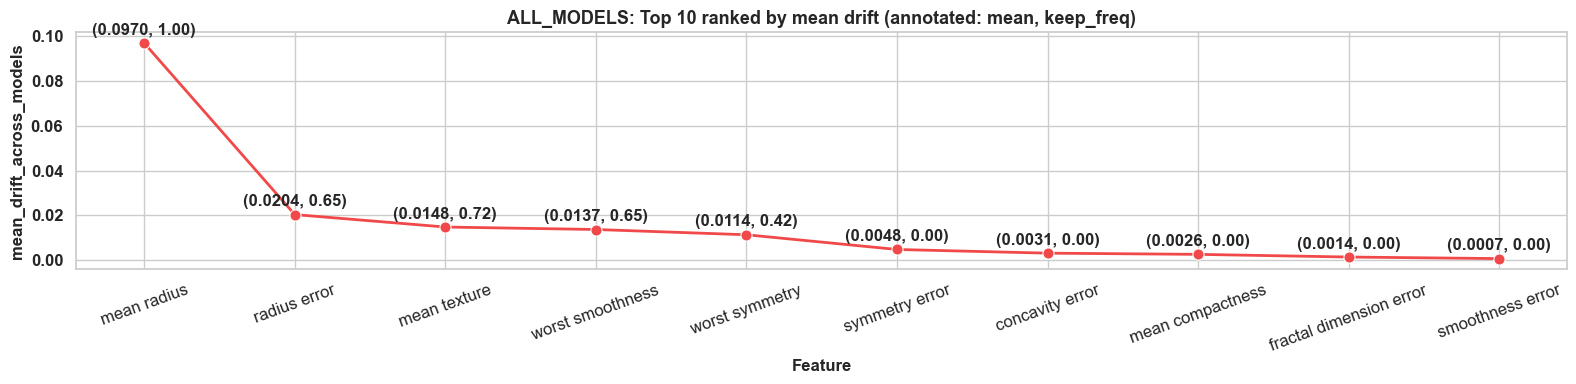

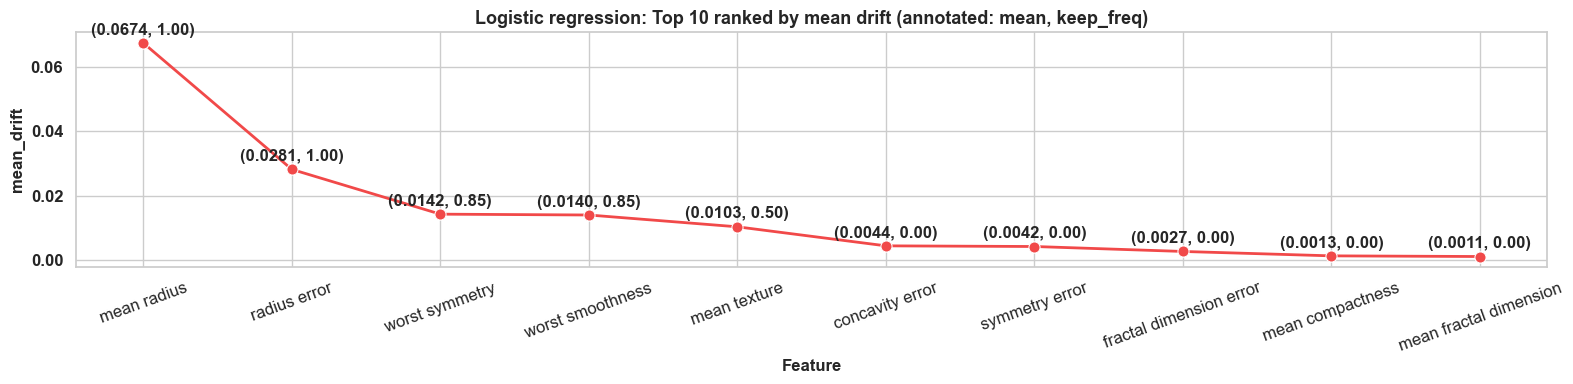

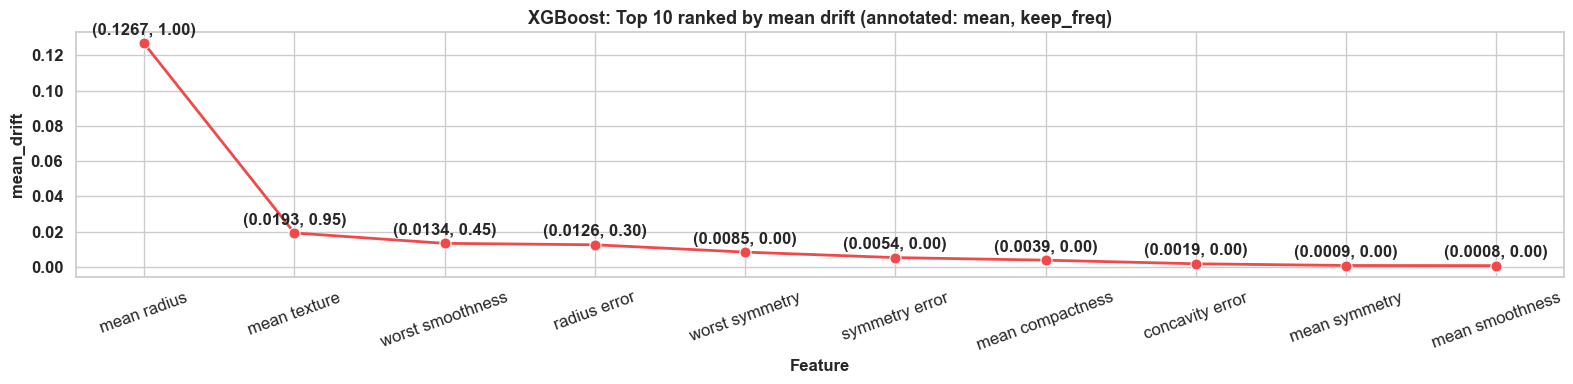

CPU times: total: 1min 45s
Wall time: 7.06 s


In [6]:
%%time

# ----------------------------
# 1) Define the candidate models you want to run SelectByShuffling on
# ----------------------------
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Keys are model IDs you’ll use later in results; values are instantiated estimators.
models = {
    "lr": LogisticRegression(),
    "xgb": XGBClassifier(),
}

# ----------------------------
# 2) Run SelectByShuffling multiple times ("stability runs") per model
# ----------------------------
# - Runs Feature-engine SelectByShuffling for each model in `models`
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
sbs_results = mfs.select_by_shuffling_stability(
    X=bundle["X_raw"],
    y=bundle["y"],
    models=models,
    n_runs=20,
    random_state=0,
    cv=cv,
    feature_names=bundle["feature_names"],
)

# ----------------------------
# 3) Visualize the Top-N ranked features
# ----------------------------
mfs.plot_sbs_ranked_mean_with_annotations(
    sbs_results,
    top_n=10,
    method_alias={"lr": "Logistic regression", "xgb": "XGBoost"},
    annotate_font_size=12,
    x_tick_rotation=20,
    figsize=(16, 4),
)

# ----------------------------
# 4) Extract Top-N feature names as Python lists (per model)
# ----------------------------
# This is useful for training each model using its own selected feature subset.
top_feats = mfs.get_top_features_from_sbs(sbs_results,  per_model_top_n={"lr": 8, "xgb": 8}, top_n=None)

# Per-model feature lists (ordered best -> worst by mean drift for that model)
lr_top = top_feats["lr"]
xgb_top = top_feats["xgb"]


## Config file

In [7]:
# ---------------------------------------------------------------------
# 1. Config: models, CV knobs, Optuna knobs, metric
# ---------------------------------------------------------------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


config = {
    "cv": {
        "num_trials": 3,
        "n_outer_splits": 5,
        "n_inner_splits": 4,
    },
    "optuna": {
        "n_inner_trials": 250,
        "direction": "maximize",
         "n_jobs": 1,
    },
    "metric": {
        "scoring": "roc_auc",   #  "average_precision" | "roc_auc"
        "name": "AUROC",           # "AUPRC"  | "AUROC"
    },
    "models": {
        "logistic_regression": {
            "enabled": True, # flip to False if you don't want it to run
            "feature_names": lr_top, 
            "feature_strict": True,
            "n_features": None,

            "estimator_cls": LogisticRegression,
            "params": lambda trial: {
                "solver": "saga",
                "random_state": 42,
                "l1_ratio": (
                    trial.suggest_float("l1_ratio", 0.0, 1.0)
                    if trial is not None else 0.0
                ),
                "C": (
                    trial.suggest_float("C", 1e-1, 50.0, log=True)
                    if trial is not None else None
                ),
                "max_iter": (
                    trial.suggest_int("max_iter", 150000, 350000)
                    if trial is not None else None
                ),
                # "class_weight": (
                #     trial.suggest_categorical("class_weight", [None, "balanced"])
                #     if trial is not None else None
                # ),
            },
        },

        # Random Forest model
        "random_forest": {
            "enabled": False,   # flip to False if you don't want it to run
            "estimator_cls": RandomForestClassifier,
            "params": lambda trial: {
                "n_jobs": -1,
                "random_state": 42,

                "n_estimators": (
                    trial.suggest_int("n_estimators", 50, 500)
                    if trial is not None else None
                ),
                "ccp_alpha": (
                    trial.suggest_float("ccp_alpha", 0.0, 0.1)
                    if trial is not None else None
                ),
                "class_weight": (
                    trial.suggest_categorical(
                        "class_weight",
                        [None, "balanced", "balanced_subsample"],
                    )
                    if trial is not None else None
                ),
            },
        },

        # XGBoost model
        "xgboost": {
            "enabled": True, # flip to False if you don't want it to run
            "estimator_cls": XGBClassifier,
            "feature_names": xgb_top,
            "feature_strict": True,
            "n_features": None,
            "params": lambda trial: {
                # ---- fixed / always-on params ----
                "objective": "binary:logistic",
                "eval_metric": "auc",   # "aucpr" or "auc"
                "random_state": 42,
                "n_jobs": -1,
                "verbosity": 0,
                "tree_method": "hist",    # CPU-fast; use "gpu_hist" if you have a CUDA GPU

                # ---- tunable params (else None like your other models) ----
                #"n_estimators": 500,
                "n_estimators": (
                    trial.suggest_int("n_estimators", 200, 600)
                    if trial is not None else None
                ),
                "learning_rate": (
                    trial.suggest_float("learning_rate", 1e-2, 0.3, log=True)
                    if trial is not None else None
                ),

                "max_depth": (
                    trial.suggest_int("max_depth", 2, 6)
                    if trial is not None else None
                ),
                
                "min_child_weight": (
                    trial.suggest_float("min_child_weight", 5.0, 50.0, log=True)
                    if trial is not None else None
                ),
                ## stochasticity
                "subsample": (
                    trial.suggest_float("subsample", 0.5, 1.0)
                    if trial is not None else None
                ),
                "colsample_bytree": (
                    trial.suggest_float("colsample_bytree", 0.5, 1.0)
                    if trial is not None else None
                ),

                ## regularization
                # "gamma": (
                #     trial.suggest_float("gamma", 1, 10.0, log=True)
                #     if trial is not None else None
                # ),
                "reg_alpha": (
                    trial.suggest_float("reg_alpha", 0.01, 10.0, log=True)
                    if trial is not None else None
                ),
                "reg_lambda": (
                    trial.suggest_float("reg_lambda", 1, 20.0, log=True)
                    if trial is not None else None
                ),

                # ## Weight
                # "scale_pos_weight": (
                #     trial.suggest_float("scale_pos_weight", 1.0, 5.0, log=True)
                #     if trial is not None else None
                # ),

            },
        },

    },
}


### Summarize splits and label counts

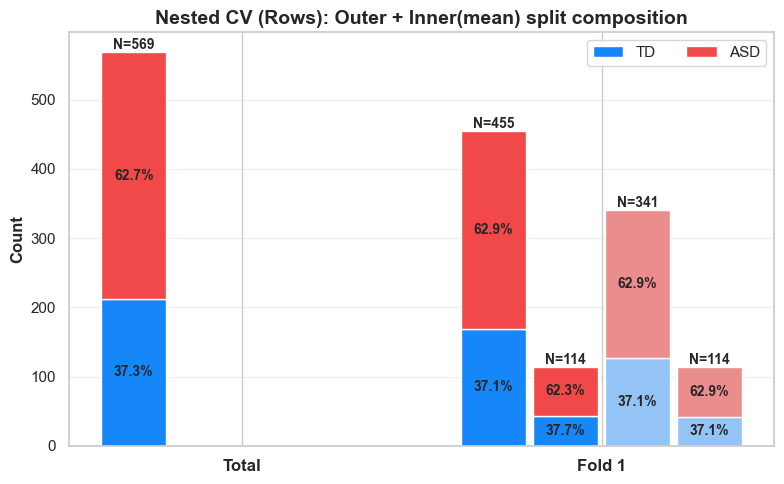

In [8]:
# ------------------------------------------------------------
# Summarize how nested CV splits your data WITHOUT training any models.
# ------------------------------------------------------------
sizes = mtci.summarize_cv_split_sizes(
    X=bundle["X_raw"],            # feature matrix (rows = observations)
    y=bundle["y"],                     # row-level labels (assumed constant within each patient)
    cfg=config,                        # must contain cfg["cv"]["n_outer_splits"], cfg["cv"]["n_inner_splits"]
    groups=None,           # patient IDs per row (same length as y)
    model_selection="StratifiedKFold",  # group-aware + stratified outer/inner splits
)


# ------------------------------------------------------------
# ROW-LEVEL plot (each row is an observation)
# Useful when you care about total number of ROWS used in each split.
# ------------------------------------------------------------
mtci.plot_outer_counts_and_class_percents(
    sizes,                         # output from summarize_cv_split_sizes(...)
    figsize=(8, 5),               # figure size
    font_size=12,                  # overall font size for labels/annotations
    show_segment_percents=True,    # write % inside each stacked segment
    show_total_labels=True,        # write N=... above each bar
    legend_loc="best",             # legend placement
    outer_fold_color=["#1587F8", "#F14949"],  # colors for Total + OUTER bars (per class)
    inner_fold_color=["#94C4F5", "#EC8D8D"], # colors for INNER(mean) bars (per class)
    class_names=['TD', 'ASD'],     # optional: e.g., ["Negative", "Positive"]
    count_level="rows",            # plot ROW counts (not unique patients)
    title=None,                    # optional: override title (else default is used)
    folds_show=1,                  # show only first 2 outer folds (Total is always shown)
)



## Run model training with nested-cv

In [10]:
%%time
# ---------------------------------------------------------------------
# Example: run nested CV for all enabled models in config
# ---------------------------------------------------------------------
# data = load_breast_cancer()
# X = data.data
# y = data.target

all_results = {}

for model_name, m_cfg in config["models"].items():
    if not m_cfg.get("enabled", False):
        continue
    print(f"\n>>> Running nested CV for model: {model_name}")
    model_results = mtci.run_nested_cv_for_model(
        model_name=model_name,        # which model config to use (must exist under cfg["models"][model_name])
        bundle=bundle,                # full superset bundle (contains X/y arrays + feature_names for per-model slicing)
        cfg=config,                   # global config: CV settings + Optuna settings + per-model params/feature selection
        # Which dataset level to use from the bundle (these must match your aggregation choice)
        x_key="X_raw",       # use the group-aggregated feature matrix (rows = groups/subjects)
        y_key="y",           # use the corresponding group-aggregated labels
        # Optional: group-aware CV (only needed if using StratifiedGroupKFold)
        groups_key=None,              # e.g., "combined_groups" if you want group-aware splitting; None means no grouping
        # Which CV splitter to use inside run_nested_cv_for_model
        model_selection="StratifiedKFold",  # stratified folds without grouping (use "StratifiedGroupKFold" if groups_key is set)
    )
    all_results[model_name] = model_results


[I 2026-02-06 13:13:03,645] A new study created in memory with name: no-name-46830ef2-4daf-45c1-8606-07648dc3ba8a



>>> Running nested CV for model: logistic_regression
[logistic_regression] X shape after slicing: (569, 8) (features=8)
[logistic_regression] feature_names (8):
  - mean radius
  - radius error
  - worst symmetry
  - worst smoothness
  - mean texture
  - concavity error
  - symmetry error
  - fractal dimension error

=== Model: logistic_regression | Trial 1/3 ===
Outer fold 1/15 (trial 0, fold 1)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2026-02-06 13:13:03,665] Trial 0 finished with value: 0.9957573823648176 and parameters: {'l1_ratio': 0.22585071664259637, 'C': 1.086833763867774, 'max_iter': 202408}. Best is trial 0 with value: 0.9957573823648176.
[I 2026-02-06 13:13:03,702] Trial 1 finished with value: 0.9945898745184283 and parameters: {'l1_ratio': 0.32485332285680235, 'C': 21.444941345856854, 'max_iter': 194950}. Best is trial 0 with value: 0.9957573823648176.
[I 2026-02-06 13:13:03,716] Trial 2 finished with value: 0.9956766600897373 and parameters: {'l1_ratio': 0.6255908354809089, 'C': 0.8701598265630114, 'max_iter': 250985}. Best is trial 0 with value: 0.9957573823648176.
[I 2026-02-06 13:13:03,736] Trial 3 finished with value: 0.9951755645847522 and parameters: {'l1_ratio': 0.6883307977229421, 'C': 2.6852408700574566, 'max_iter': 314173}. Best is trial 0 with value: 0.9957573823648176.
[I 2026-02-06 13:13:03,778] Trial 4 finished with value: 0.9940915139848565 and parameters: {'l1_ratio': 0.5814253091562415

[I 2026-02-06 13:13:08,156] A new study created in memory with name: no-name-c189c1d1-4b1b-4328-94a1-af9a629761a2


[I 2026-02-06 13:13:07,988] Trial 241 finished with value: 0.9963388210399347 and parameters: {'l1_ratio': 0.0001040892510191134, 'C': 0.2360868481641767, 'max_iter': 192203}. Best is trial 84 with value: 0.9964214929976067.
[I 2026-02-06 13:13:08,008] Trial 242 finished with value: 0.9963388210399347 and parameters: {'l1_ratio': 0.026318475839244626, 'C': 0.20378139280872154, 'max_iter': 194796}. Best is trial 84 with value: 0.9964214929976067.
[I 2026-02-06 13:13:08,028] Trial 243 finished with value: 0.9962561490822628 and parameters: {'l1_ratio': 0.0502710023513139, 'C': 0.2623373885441537, 'max_iter': 187114}. Best is trial 84 with value: 0.9964214929976067.
[I 2026-02-06 13:13:08,050] Trial 244 finished with value: 0.9964214929976067 and parameters: {'l1_ratio': 0.014638358609210571, 'C': 0.21631090343667791, 'max_iter': 182604}. Best is trial 84 with value: 0.9964214929976067.
[I 2026-02-06 13:13:08,071] Trial 245 finished with value: 0.9962569343710843 and parameters: {'l1_rati

  0%|          | 0/250 [00:00<?, ?it/s]

[I 2026-02-06 13:13:08,184] Trial 0 finished with value: 0.9905898298923601 and parameters: {'l1_ratio': 0.7623895489756066, 'C': 38.447539408083976, 'max_iter': 250119}. Best is trial 0 with value: 0.9905898298923601.
[I 2026-02-06 13:13:08,198] Trial 1 finished with value: 0.9915070201571186 and parameters: {'l1_ratio': 0.7830522194343256, 'C': 0.6332867692211167, 'max_iter': 263986}. Best is trial 1 with value: 0.9915070201571186.
[I 2026-02-06 13:13:08,220] Trial 2 finished with value: 0.9906725018500321 and parameters: {'l1_ratio': 0.4145482813006718, 'C': 11.946456733078232, 'max_iter': 221158}. Best is trial 1 with value: 0.9915070201571186.
[I 2026-02-06 13:13:08,239] Trial 3 finished with value: 0.9908417451305594 and parameters: {'l1_ratio': 0.2847526927017823, 'C': 6.3871009635170575, 'max_iter': 218300}. Best is trial 1 with value: 0.9915070201571186.
[I 2026-02-06 13:13:08,258] Trial 4 finished with value: 0.9909255814820015 and parameters: {'l1_ratio': 0.12540211184088135

[I 2026-02-06 13:13:12,741] A new study created in memory with name: no-name-4a304d4d-cd7c-4b49-b58c-2a3830087959


[I 2026-02-06 13:13:12,737] Trial 249 finished with value: 0.9918377079878062 and parameters: {'l1_ratio': 0.5307750586227987, 'C': 0.4638699516665745, 'max_iter': 329090}. Best is trial 51 with value: 0.9920053806906902.
Outer fold 3/15 (trial 0, fold 3)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2026-02-06 13:13:12,763] Trial 0 finished with value: 0.9934385057112702 and parameters: {'l1_ratio': 0.1541099154946758, 'C': 4.919107616120719, 'max_iter': 198514}. Best is trial 0 with value: 0.9934385057112702.
[I 2026-02-06 13:13:12,774] Trial 1 finished with value: 0.9931963659649542 and parameters: {'l1_ratio': 0.27867572949333996, 'C': 0.3275853548498597, 'max_iter': 320289}. Best is trial 0 with value: 0.9934385057112702.
[I 2026-02-06 13:13:12,785] Trial 2 finished with value: 0.992784982938111 and parameters: {'l1_ratio': 0.13223645002778794, 'C': 0.10467640993311149, 'max_iter': 308926}. Best is trial 0 with value: 0.9934385057112702.
[I 2026-02-06 13:13:12,811] Trial 3 finished with value: 0.9934377204224485 and parameters: {'l1_ratio': 0.5612528847501216, 'C': 33.3616628286051, 'max_iter': 329947}. Best is trial 0 with value: 0.9934385057112702.
[I 2026-02-06 13:13:12,833] Trial 4 finished with value: 0.9931955806761326 and parameters: {'l1_ratio': 0.29338246551211944,

[I 2026-02-06 13:13:18,814] A new study created in memory with name: no-name-81ac0a8a-2097-4cb1-826b-8118cc5ae42a


[I 2026-02-06 13:13:18,773] Trial 248 finished with value: 0.9934377204224485 and parameters: {'l1_ratio': 0.0005571062806155533, 'C': 7.776756422606901, 'max_iter': 336632}. Best is trial 81 with value: 0.9935203923801206.
[I 2026-02-06 13:13:18,807] Trial 249 finished with value: 0.9935203923801206 and parameters: {'l1_ratio': 0.040664534716549613, 'C': 5.184788864153404, 'max_iter': 330585}. Best is trial 81 with value: 0.9935203923801206.
Outer fold 4/15 (trial 0, fold 4)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2026-02-06 13:13:18,837] Trial 0 finished with value: 0.9886444528497427 and parameters: {'l1_ratio': 0.07288609232864407, 'C': 9.225644139704176, 'max_iter': 164978}. Best is trial 0 with value: 0.9886444528497427.
[I 2026-02-06 13:13:18,851] Trial 1 finished with value: 0.9885664926250006 and parameters: {'l1_ratio': 0.7851486495413825, 'C': 1.0993401769142155, 'max_iter': 248676}. Best is trial 0 with value: 0.9886444528497427.
[I 2026-02-06 13:13:18,870] Trial 2 finished with value: 0.9886436675609211 and parameters: {'l1_ratio': 0.38807988570488416, 'C': 9.761525318502416, 'max_iter': 336338}. Best is trial 0 with value: 0.9886444528497427.
[I 2026-02-06 13:13:18,891] Trial 3 finished with value: 0.9884791089343987 and parameters: {'l1_ratio': 0.3775768960006405, 'C': 38.89575557492076, 'max_iter': 344435}. Best is trial 0 with value: 0.9886444528497427.
[I 2026-02-06 13:13:18,905] Trial 4 finished with value: 0.9886475940050293 and parameters: {'l1_ratio': 0.5847393493037728, 

[I 2026-02-06 13:13:23,095] A new study created in memory with name: no-name-9b591f85-126d-4f79-b77b-13a8d6c35a67


[I 2026-02-06 13:13:23,092] Trial 249 finished with value: 0.9896521679603895 and parameters: {'l1_ratio': 0.3979307893086547, 'C': 0.12682605737344768, 'max_iter': 191195}. Best is trial 43 with value: 0.9906348079865932.
Outer fold 5/15 (trial 0, fold 5)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2026-02-06 13:13:23,121] Trial 0 finished with value: 0.9923633369987366 and parameters: {'l1_ratio': 0.3036365999902515, 'C': 4.058593635633453, 'max_iter': 156910}. Best is trial 0 with value: 0.9923633369987366.
[I 2026-02-06 13:13:23,149] Trial 1 finished with value: 0.9918680905415265 and parameters: {'l1_ratio': 0.07695468601182998, 'C': 43.34111995870436, 'max_iter': 246592}. Best is trial 0 with value: 0.9923633369987366.
[I 2026-02-06 13:13:23,161] Trial 2 finished with value: 0.9910602178965264 and parameters: {'l1_ratio': 0.8070767828511537, 'C': 0.1727561913109768, 'max_iter': 279779}. Best is trial 0 with value: 0.9923633369987366.
[I 2026-02-06 13:13:23,184] Trial 3 finished with value: 0.9920342197456921 and parameters: {'l1_ratio': 0.701059615261684, 'C': 9.052619914604403, 'max_iter': 228662}. Best is trial 0 with value: 0.9923633369987366.
[I 2026-02-06 13:13:23,207] Trial 4 finished with value: 0.9920342197456921 and parameters: {'l1_ratio': 0.9391681962906752, 'C

[I 2026-02-06 13:13:27,631] A new study created in memory with name: no-name-b292951c-69c0-46f5-9c5a-951b69504f85


[I 2026-02-06 13:13:27,544] Trial 245 finished with value: 0.993275084399593 and parameters: {'l1_ratio': 0.02977024206836574, 'C': 0.2785420544429103, 'max_iter': 326790}. Best is trial 161 with value: 0.993275084399593.
[I 2026-02-06 13:13:27,565] Trial 246 finished with value: 0.993275084399593 and parameters: {'l1_ratio': 0.03210497781081589, 'C': 0.29687808735602533, 'max_iter': 326966}. Best is trial 161 with value: 0.993275084399593.
[I 2026-02-06 13:13:27,585] Trial 247 finished with value: 0.993192412441921 and parameters: {'l1_ratio': 0.027379074609275612, 'C': 0.4196375260100241, 'max_iter': 332208}. Best is trial 161 with value: 0.993275084399593.
[I 2026-02-06 13:13:27,607] Trial 248 finished with value: 0.993192412441921 and parameters: {'l1_ratio': 0.044421080117831274, 'C': 0.3076654198658139, 'max_iter': 327439}. Best is trial 161 with value: 0.993275084399593.
[I 2026-02-06 13:13:27,628] Trial 249 finished with value: 0.993192412441921 and parameters: {'l1_ratio': 0.0

  0%|          | 0/250 [00:00<?, ?it/s]

[I 2026-02-06 13:13:27,648] Trial 0 finished with value: 0.9906213497609255 and parameters: {'l1_ratio': 0.5963840876142733, 'C': 0.620525946287636, 'max_iter': 223398}. Best is trial 0 with value: 0.9906213497609255.
[I 2026-02-06 13:13:27,668] Trial 1 finished with value: 0.9907886162799364 and parameters: {'l1_ratio': 0.20471323001465747, 'C': 15.977892189079002, 'max_iter': 155217}. Best is trial 1 with value: 0.9907886162799364.
[I 2026-02-06 13:13:27,685] Trial 2 finished with value: 0.990617477474667 and parameters: {'l1_ratio': 0.31778631432123805, 'C': 0.11799349738540571, 'max_iter': 310469}. Best is trial 1 with value: 0.9907886162799364.
[I 2026-02-06 13:13:27,714] Trial 3 finished with value: 0.9906224870757707 and parameters: {'l1_ratio': 0.45051781587079254, 'C': 43.54881321956904, 'max_iter': 247840}. Best is trial 1 with value: 0.9907886162799364.
[I 2026-02-06 13:13:27,726] Trial 4 finished with value: 0.9911185459007273 and parameters: {'l1_ratio': 0.2148920996897744

[I 2026-02-06 13:13:31,889] A new study created in memory with name: no-name-c4c44207-30e9-4f7c-8f99-12fcc5a7f2df


Outer fold 7/15 (trial 1, fold 2)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2026-02-06 13:13:31,903] Trial 0 finished with value: 0.9905211577388535 and parameters: {'l1_ratio': 0.8361838321864307, 'C': 0.19061650294814594, 'max_iter': 252197}. Best is trial 0 with value: 0.9905211577388535.
[I 2026-02-06 13:13:31,918] Trial 1 finished with value: 0.9918500559775535 and parameters: {'l1_ratio': 0.5002722617832376, 'C': 2.177085306052968, 'max_iter': 205290}. Best is trial 1 with value: 0.9918500559775535.
[I 2026-02-06 13:13:31,943] Trial 2 finished with value: 0.9916847120622097 and parameters: {'l1_ratio': 0.83856347260579, 'C': 20.84082199026465, 'max_iter': 171320}. Best is trial 1 with value: 0.9918500559775535.
[I 2026-02-06 13:13:31,959] Trial 3 finished with value: 0.9920165642866674 and parameters: {'l1_ratio': 0.07146250789751729, 'C': 2.5758520877094844, 'max_iter': 230534}. Best is trial 3 with value: 0.9920165642866674.
[I 2026-02-06 13:13:31,980] Trial 4 finished with value: 0.9918512203713234 and parameters: {'l1_ratio': 0.16361251831156498, 

[I 2026-02-06 13:13:36,849] A new study created in memory with name: no-name-a6b4d1da-e80b-4538-bfe0-4d0ae5d816c6


[I 2026-02-06 13:13:36,844] Trial 249 finished with value: 0.9919335132240471 and parameters: {'l1_ratio': 0.27277451757072346, 'C': 1.1521464909823043, 'max_iter': 176256}. Best is trial 11 with value: 0.9921004006381094.
Outer fold 8/15 (trial 1, fold 3)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2026-02-06 13:13:36,884] Trial 0 finished with value: 0.9952083571627872 and parameters: {'l1_ratio': 0.8958272678944691, 'C': 9.91190317048847, 'max_iter': 189471}. Best is trial 0 with value: 0.9952083571627872.
[I 2026-02-06 13:13:36,904] Trial 1 finished with value: 0.9957004624647108 and parameters: {'l1_ratio': 0.25576813604404125, 'C': 5.273051779442935, 'max_iter': 213783}. Best is trial 1 with value: 0.9957004624647108.
[I 2026-02-06 13:13:36,920] Trial 2 finished with value: 0.9963551767105648 and parameters: {'l1_ratio': 0.09780143050023582, 'C': 1.264708431678945, 'max_iter': 303051}. Best is trial 2 with value: 0.9963551767105648.
[I 2026-02-06 13:13:36,942] Trial 3 finished with value: 0.9957004624647108 and parameters: {'l1_ratio': 0.02422903753072858, 'C': 6.72417639231986, 'max_iter': 329175}. Best is trial 2 with value: 0.9963551767105648.
[I 2026-02-06 13:13:36,976] Trial 4 finished with value: 0.9949626971562362 and parameters: {'l1_ratio': 0.44291142643783, 'C':

[I 2026-02-06 13:13:41,479] A new study created in memory with name: no-name-eee2a175-1f9e-473c-81aa-db441dd6e100


[I 2026-02-06 13:13:41,438] Trial 248 finished with value: 0.9965189500482655 and parameters: {'l1_ratio': 0.1505813287346178, 'C': 0.6043102329694535, 'max_iter': 339610}. Best is trial 22 with value: 0.9966016220059374.
[I 2026-02-06 13:13:41,474] Trial 249 finished with value: 0.9954548024581598 and parameters: {'l1_ratio': 0.04069900517166382, 'C': 14.630586472090505, 'max_iter': 310116}. Best is trial 22 with value: 0.9966016220059374.
Outer fold 9/15 (trial 1, fold 4)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2026-02-06 13:13:41,507] Trial 0 finished with value: 0.9911078768043229 and parameters: {'l1_ratio': 0.6036225503961427, 'C': 20.719787277920318, 'max_iter': 280739}. Best is trial 0 with value: 0.9911078768043229.
[I 2026-02-06 13:13:41,520] Trial 1 finished with value: 0.9917703897805437 and parameters: {'l1_ratio': 0.37045798167078703, 'C': 1.0615833324236628, 'max_iter': 349904}. Best is trial 1 with value: 0.9917703897805437.
[I 2026-02-06 13:13:41,537] Trial 2 finished with value: 0.9911936628383565 and parameters: {'l1_ratio': 0.2304474877615328, 'C': 4.103491305375689, 'max_iter': 230064}. Best is trial 1 with value: 0.9917703897805437.
[I 2026-02-06 13:13:41,562] Trial 3 finished with value: 0.9911078768043229 and parameters: {'l1_ratio': 0.28721716802488406, 'C': 33.99183034722525, 'max_iter': 282590}. Best is trial 1 with value: 0.9917703897805437.
[I 2026-02-06 13:13:41,580] Trial 4 finished with value: 0.9915227800914012 and parameters: {'l1_ratio': 0.6764876623672686,

[I 2026-02-06 13:13:45,567] A new study created in memory with name: no-name-a883d39c-6776-419e-b099-9d246ac5d243


[I 2026-02-06 13:13:45,545] Trial 248 finished with value: 0.9922675588414206 and parameters: {'l1_ratio': 0.009968056870462979, 'C': 0.2214261705228881, 'max_iter': 189583}. Best is trial 165 with value: 0.9925970551994134.
[I 2026-02-06 13:13:45,563] Trial 249 finished with value: 0.9907928135132934 and parameters: {'l1_ratio': 0.7813207309736454, 'C': 0.1878797200729351, 'max_iter': 187241}. Best is trial 165 with value: 0.9925970551994134.
Outer fold 10/15 (trial 1, fold 5)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2026-02-06 13:13:45,592] Trial 0 finished with value: 0.9897722359133265 and parameters: {'l1_ratio': 0.9681588312773767, 'C': 13.27400349607222, 'max_iter': 193465}. Best is trial 0 with value: 0.9897722359133265.
[I 2026-02-06 13:13:45,612] Trial 1 finished with value: 0.9901934485899029 and parameters: {'l1_ratio': 0.6828809384993317, 'C': 0.13661423829312144, 'max_iter': 324365}. Best is trial 1 with value: 0.9901934485899029.
[I 2026-02-06 13:13:45,633] Trial 2 finished with value: 0.9899375798286705 and parameters: {'l1_ratio': 0.9733381157220536, 'C': 5.172082838466361, 'max_iter': 168102}. Best is trial 1 with value: 0.9901934485899029.
[I 2026-02-06 13:13:45,652] Trial 3 finished with value: 0.9901021384551927 and parameters: {'l1_ratio': 0.3728675394448149, 'C': 4.892815651895505, 'max_iter': 273879}. Best is trial 1 with value: 0.9901934485899029.
[I 2026-02-06 13:13:45,671] Trial 4 finished with value: 0.9899375798286705 and parameters: {'l1_ratio': 0.3596981797709907, '

[I 2026-02-06 13:13:49,898] A new study created in memory with name: no-name-485a1f92-698e-4d05-8ee1-6f41da3bd86e


[I 2026-02-06 13:13:49,809] Trial 245 finished with value: 0.9918374642774823 and parameters: {'l1_ratio': 0.004775918096371762, 'C': 0.1008224384498543, 'max_iter': 281361}. Best is trial 49 with value: 0.9919201362351543.
[I 2026-02-06 13:13:49,830] Trial 246 finished with value: 0.9917555776086319 and parameters: {'l1_ratio': 0.0447249514007576, 'C': 0.11263658783657121, 'max_iter': 297982}. Best is trial 49 with value: 0.9919201362351543.
[I 2026-02-06 13:13:49,851] Trial 247 finished with value: 0.9919201362351543 and parameters: {'l1_ratio': 0.06388645156217018, 'C': 0.1000019243651719, 'max_iter': 291428}. Best is trial 49 with value: 0.9919201362351543.
[I 2026-02-06 13:13:49,872] Trial 248 finished with value: 0.991838249566304 and parameters: {'l1_ratio': 0.09928847400846497, 'C': 0.10009542546164121, 'max_iter': 293620}. Best is trial 49 with value: 0.9919201362351543.
[I 2026-02-06 13:13:49,894] Trial 249 finished with value: 0.9917555776086319 and parameters: {'l1_ratio': 

  0%|          | 0/250 [00:00<?, ?it/s]

[I 2026-02-06 13:13:49,917] Trial 0 finished with value: 0.9908525496215883 and parameters: {'l1_ratio': 0.5015687968375466, 'C': 1.9348064295456489, 'max_iter': 337576}. Best is trial 0 with value: 0.9908525496215883.
[I 2026-02-06 13:13:49,938] Trial 1 finished with value: 0.9904395689381769 and parameters: {'l1_ratio': 0.15662628778667964, 'C': 21.207680322580924, 'max_iter': 199477}. Best is trial 0 with value: 0.9908525496215883.
[I 2026-02-06 13:13:49,959] Trial 2 finished with value: 0.9904395689381769 and parameters: {'l1_ratio': 0.16510867290063636, 'C': 15.895732820779388, 'max_iter': 167707}. Best is trial 0 with value: 0.9908525496215883.
[I 2026-02-06 13:13:49,971] Trial 3 finished with value: 0.9907621060124745 and parameters: {'l1_ratio': 0.7891211308032855, 'C': 0.39153527248377085, 'max_iter': 216784}. Best is trial 0 with value: 0.9908525496215883.
[I 2026-02-06 13:13:49,983] Trial 4 finished with value: 0.9914234275160005 and parameters: {'l1_ratio': 0.08013931440967

[I 2026-02-06 13:13:54,157] A new study created in memory with name: no-name-8ccf332f-2da2-4db5-b691-80195de36ee3


[I 2026-02-06 13:13:54,153] Trial 249 finished with value: 0.9904212635849551 and parameters: {'l1_ratio': 0.8545833609183298, 'C': 0.2059886547959239, 'max_iter': 200359}. Best is trial 116 with value: 0.9919210027607505.
Outer fold 12/15 (trial 2, fold 2)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2026-02-06 13:13:54,180] Trial 0 finished with value: 0.9908809012559421 and parameters: {'l1_ratio': 0.29985263322336564, 'C': 11.825056931683477, 'max_iter': 274124}. Best is trial 0 with value: 0.9908809012559421.
[I 2026-02-06 13:13:54,194] Trial 1 finished with value: 0.9916319623165348 and parameters: {'l1_ratio': 0.7726182079031233, 'C': 0.8003913446469406, 'max_iter': 235012}. Best is trial 1 with value: 0.9916319623165348.
[I 2026-02-06 13:13:54,211] Trial 2 finished with value: 0.9912127534804 and parameters: {'l1_ratio': 0.16142501858658154, 'C': 4.299897144258548, 'max_iter': 155192}. Best is trial 1 with value: 0.9916319623165348.
[I 2026-02-06 13:13:54,226] Trial 3 finished with value: 0.9921272087737449 and parameters: {'l1_ratio': 0.38929920721661004, 'C': 1.0055953842278467, 'max_iter': 207397}. Best is trial 3 with value: 0.9921272087737449.
[I 2026-02-06 13:13:54,239] Trial 4 finished with value: 0.9927074830550919 and parameters: {'l1_ratio': 0.19722347042677002,

[I 2026-02-06 13:13:58,568] A new study created in memory with name: no-name-fc1e3847-b03a-48cd-8e10-831cb6bc67f5


[I 2026-02-06 13:13:58,524] Trial 247 finished with value: 0.9925437097173913 and parameters: {'l1_ratio': 0.2591994788047669, 'C': 0.13273761717889138, 'max_iter': 245507}. Best is trial 100 with value: 0.9928732331543092.
[I 2026-02-06 13:13:58,544] Trial 248 finished with value: 0.9927905611966372 and parameters: {'l1_ratio': 0.28815177292408917, 'C': 0.12165672132425456, 'max_iter': 236225}. Best is trial 100 with value: 0.9928732331543092.
[I 2026-02-06 13:13:58,564] Trial 249 finished with value: 0.9928732331543092 and parameters: {'l1_ratio': 0.3715588293432483, 'C': 0.10038126069129141, 'max_iter': 257814}. Best is trial 100 with value: 0.9928732331543092.
Outer fold 13/15 (trial 2, fold 3)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2026-02-06 13:13:58,584] Trial 0 finished with value: 0.9963064888036227 and parameters: {'l1_ratio': 0.7152615116028069, 'C': 0.40031707552658613, 'max_iter': 163481}. Best is trial 0 with value: 0.9963064888036227.
[I 2026-02-06 13:13:58,633] Trial 1 finished with value: 0.9962214880584107 and parameters: {'l1_ratio': 0.9226851264114999, 'C': 38.97649675870041, 'max_iter': 244417}. Best is trial 0 with value: 0.9963064888036227.
[I 2026-02-06 13:13:58,647] Trial 2 finished with value: 0.996962367443247 and parameters: {'l1_ratio': 0.3832446049006444, 'C': 1.5710449373079227, 'max_iter': 246203}. Best is trial 2 with value: 0.996962367443247.
[I 2026-02-06 13:13:58,673] Trial 3 finished with value: 0.9965509844164038 and parameters: {'l1_ratio': 0.5417780235267496, 'C': 9.60033792537789, 'max_iter': 247843}. Best is trial 2 with value: 0.996962367443247.
[I 2026-02-06 13:13:58,703] Trial 4 finished with value: 0.9965509844164038 and parameters: {'l1_ratio': 0.05234045740599991, 'C'

[I 2026-02-06 13:14:03,147] A new study created in memory with name: no-name-3d678705-2616-4505-9b1e-f506198c78e8


[I 2026-02-06 13:14:03,143] Trial 249 finished with value: 0.9971269260697692 and parameters: {'l1_ratio': 0.1373695169702976, 'C': 1.1684390319177647, 'max_iter': 314173}. Best is trial 216 with value: 0.9973745357589119.
Outer fold 14/15 (trial 2, fold 4)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2026-02-06 13:14:03,166] Trial 0 finished with value: 0.9938135758998434 and parameters: {'l1_ratio': 0.33043346247095073, 'C': 1.7063751424349483, 'max_iter': 163793}. Best is trial 0 with value: 0.9938135758998434.
[I 2026-02-06 13:14:03,180] Trial 1 finished with value: 0.9919157765282478 and parameters: {'l1_ratio': 0.9530136404293744, 'C': 0.24559382916905545, 'max_iter': 235029}. Best is trial 0 with value: 0.9938135758998434.
[I 2026-02-06 13:14:03,204] Trial 2 finished with value: 0.9935655600268276 and parameters: {'l1_ratio': 0.1361416148223089, 'C': 9.763993563300259, 'max_iter': 244723}. Best is trial 0 with value: 0.9938135758998434.
[I 2026-02-06 13:14:03,218] Trial 3 finished with value: 0.9909253377716774 and parameters: {'l1_ratio': 0.9916068177591565, 'C': 0.18447024056205139, 'max_iter': 306470}. Best is trial 0 with value: 0.9938135758998434.
[I 2026-02-06 13:14:03,246] Trial 4 finished with value: 0.9934037363717187 and parameters: {'l1_ratio': 0.568534604869378

[I 2026-02-06 13:14:08,463] A new study created in memory with name: no-name-1f3ca49b-c3fe-4030-856e-768e7712b94e


[I 2026-02-06 13:14:08,403] Trial 247 finished with value: 0.9938974122512854 and parameters: {'l1_ratio': 0.2932939939576242, 'C': 2.155493012118827, 'max_iter': 285879}. Best is trial 18 with value: 0.9938974122512854.
[I 2026-02-06 13:14:08,428] Trial 248 finished with value: 0.9937297395484015 and parameters: {'l1_ratio': 0.3573662897625721, 'C': 1.5152396563554131, 'max_iter': 198447}. Best is trial 18 with value: 0.9938974122512854.
[I 2026-02-06 13:14:08,455] Trial 249 finished with value: 0.9938974122512854 and parameters: {'l1_ratio': 0.4402327768384865, 'C': 1.7534980136502496, 'max_iter': 307265}. Best is trial 18 with value: 0.9938974122512854.
Outer fold 15/15 (trial 2, fold 5)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2026-02-06 13:14:08,479] Trial 0 finished with value: 0.9900752220038577 and parameters: {'l1_ratio': 0.6370461110211925, 'C': 0.17424296251324706, 'max_iter': 286214}. Best is trial 0 with value: 0.9900752220038577.
[I 2026-02-06 13:14:08,508] Trial 1 finished with value: 0.9871966239729506 and parameters: {'l1_ratio': 0.49618330233982344, 'C': 30.282090943840874, 'max_iter': 297886}. Best is trial 0 with value: 0.9900752220038577.
[I 2026-02-06 13:14:08,538] Trial 2 finished with value: 0.9871147373041003 and parameters: {'l1_ratio': 0.9641290039996346, 'C': 22.714630349349672, 'max_iter': 230199}. Best is trial 0 with value: 0.9900752220038577.
[I 2026-02-06 13:14:08,576] Trial 3 finished with value: 0.9871139520152785 and parameters: {'l1_ratio': 0.36493112840295805, 'C': 42.999088264362165, 'max_iter': 191444}. Best is trial 0 with value: 0.9900752220038577.
[I 2026-02-06 13:14:08,590] Trial 4 finished with value: 0.9901523969397783 and parameters: {'l1_ratio': 0.62289602262286

[I 2026-02-06 13:14:13,066] A new study created in memory with name: no-name-64691475-0bdc-4078-9d92-2bf2b3941a39



>>> Running nested CV for model: xgboost
[xgboost] X shape after slicing: (569, 8) (features=8)
[xgboost] feature_names (8):
  - mean radius
  - mean texture
  - worst smoothness
  - radius error
  - worst symmetry
  - symmetry error
  - mean compactness
  - concavity error

=== Model: xgboost | Trial 1/3 ===
Outer fold 1/15 (trial 0, fold 1)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2026-02-06 13:14:13,186] Trial 0 finished with value: 0.8394050240287547 and parameters: {'n_estimators': 315, 'learning_rate': 0.020960215378210675, 'max_depth': 2, 'min_child_weight': 28.971620973190962, 'subsample': 0.6638933926960667, 'colsample_bytree': 0.7394840896445134, 'reg_alpha': 0.013587508174006889, 'reg_lambda': 1.5666406497881147}. Best is trial 0 with value: 0.8394050240287547.
[I 2026-02-06 13:14:13,446] Trial 1 finished with value: 0.9790500106582649 and parameters: {'n_estimators': 519, 'learning_rate': 0.061523306165608596, 'max_depth': 3, 'min_child_weight': 8.578378358658277, 'subsample': 0.9884429127197425, 'colsample_bytree': 0.9040041532829475, 'reg_alpha': 7.240911100666634, 'reg_lambda': 18.282998604879552}. Best is trial 1 with value: 0.9790500106582649.
[I 2026-02-06 13:14:13,663] Trial 2 finished with value: 0.9767690986574054 and parameters: {'n_estimators': 566, 'learning_rate': 0.016350993968208653, 'max_depth': 4, 'min_child_weight': 17.841674483808

[I 2026-02-06 13:14:42,440] A new study created in memory with name: no-name-3a501864-8850-4054-a8eb-3bbcdcb170cc


[I 2026-02-06 13:14:42,400] Trial 249 finished with value: 0.9874713396659024 and parameters: {'n_estimators': 266, 'learning_rate': 0.2027202117957429, 'max_depth': 6, 'min_child_weight': 5.404362903064367, 'subsample': 0.8503725659173503, 'colsample_bytree': 0.7543071710431116, 'reg_alpha': 0.021256494097992212, 'reg_lambda': 2.5513354762153204}. Best is trial 140 with value: 0.9893898544150346.
Outer fold 2/15 (trial 0, fold 2)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2026-02-06 13:14:42,599] Trial 0 finished with value: 0.9773885832219847 and parameters: {'n_estimators': 270, 'learning_rate': 0.019117456650555593, 'max_depth': 6, 'min_child_weight': 12.971103646781772, 'subsample': 0.7485347037201119, 'colsample_bytree': 0.9277217275180972, 'reg_alpha': 0.7957643606240561, 'reg_lambda': 2.548606122539841}. Best is trial 0 with value: 0.9773885832219847.
[I 2026-02-06 13:14:42,675] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 213, 'learning_rate': 0.07936270393999481, 'max_depth': 5, 'min_child_weight': 36.400300009528465, 'subsample': 0.6136265448101754, 'colsample_bytree': 0.9384636284196988, 'reg_alpha': 0.5258250424159471, 'reg_lambda': 1.9852738161001722}. Best is trial 0 with value: 0.9773885832219847.
[I 2026-02-06 13:14:42,900] Trial 2 finished with value: 0.9819236532459182 and parameters: {'n_estimators': 433, 'learning_rate': 0.015049480946731943, 'max_depth': 2, 'min_child_weight': 5.027862625691526, 'subsample': 

[I 2026-02-06 13:15:23,832] A new study created in memory with name: no-name-78a826db-e635-4ed5-943b-c521da7ada3f


[I 2026-02-06 13:15:23,791] Trial 249 finished with value: 0.986806633296766 and parameters: {'n_estimators': 361, 'learning_rate': 0.04576451696021172, 'max_depth': 3, 'min_child_weight': 5.243001050306921, 'subsample': 0.6662088813259155, 'colsample_bytree': 0.5506989880600648, 'reg_alpha': 0.012114012406309478, 'reg_lambda': 1.445366164419472}. Best is trial 202 with value: 0.9877970720533363.
Outer fold 3/15 (trial 0, fold 3)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2026-02-06 13:15:23,949] Trial 0 finished with value: 0.9832543657725856 and parameters: {'n_estimators': 285, 'learning_rate': 0.28204733876000826, 'max_depth': 4, 'min_child_weight': 9.347032705360721, 'subsample': 0.7782597877547052, 'colsample_bytree': 0.8527367973568654, 'reg_alpha': 0.19830064529036812, 'reg_lambda': 17.739207832657677}. Best is trial 0 with value: 0.9832543657725856.
[I 2026-02-06 13:15:24,051] Trial 1 finished with value: 0.9816786160546396 and parameters: {'n_estimators': 323, 'learning_rate': 0.0808052000889771, 'max_depth': 3, 'min_child_weight': 9.693306606122933, 'subsample': 0.6384278756229169, 'colsample_bytree': 0.6796902879505997, 'reg_alpha': 0.08687538372825042, 'reg_lambda': 2.0387324939714366}. Best is trial 0 with value: 0.9832543657725856.
[I 2026-02-06 13:15:24,132] Trial 2 finished with value: 0.9830009070356679 and parameters: {'n_estimators': 206, 'learning_rate': 0.0653948286978971, 'max_depth': 6, 'min_child_weight': 6.45554543043499, 's

[I 2026-02-06 13:16:07,859] A new study created in memory with name: no-name-fa166c07-553c-46e5-9d76-7a3d494c3134


Outer fold 4/15 (trial 0, fold 4)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2026-02-06 13:16:08,035] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 531, 'learning_rate': 0.2835160803778567, 'max_depth': 3, 'min_child_weight': 42.8098945700901, 'subsample': 0.5482580991995125, 'colsample_bytree': 0.6162789821359808, 'reg_alpha': 1.3635877581324192, 'reg_lambda': 4.61152691289246}. Best is trial 0 with value: 0.5.
[I 2026-02-06 13:16:08,171] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 525, 'learning_rate': 0.24744457436877482, 'max_depth': 2, 'min_child_weight': 24.54118585761312, 'subsample': 0.521777864410588, 'colsample_bytree': 0.8895571071359086, 'reg_alpha': 0.05702652302739911, 'reg_lambda': 6.854026325125713}. Best is trial 0 with value: 0.5.
[I 2026-02-06 13:16:08,249] Trial 2 finished with value: 0.9682953042328042 and parameters: {'n_estimators': 277, 'learning_rate': 0.051217425895722785, 'max_depth': 3, 'min_child_weight': 19.007655466127293, 'subsample': 0.694384747078232, 'colsample_bytree': 0.5253457858

[I 2026-02-06 13:16:42,308] A new study created in memory with name: no-name-b7de67d2-6a3c-4f40-bbaf-68fecb569a0b


[I 2026-02-06 13:16:42,276] Trial 249 finished with value: 0.9843617854846564 and parameters: {'n_estimators': 294, 'learning_rate': 0.1609746701850456, 'max_depth': 4, 'min_child_weight': 5.287190204409891, 'subsample': 0.7848232552933044, 'colsample_bytree': 0.9766160067885064, 'reg_alpha': 0.042924469546152255, 'reg_lambda': 14.936559955966613}. Best is trial 247 with value: 0.985678606522858.
Outer fold 5/15 (trial 0, fold 5)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2026-02-06 13:16:42,436] Trial 0 finished with value: 0.9761956482651292 and parameters: {'n_estimators': 363, 'learning_rate': 0.08651614162372359, 'max_depth': 5, 'min_child_weight': 13.001424264737247, 'subsample': 0.6684889261334332, 'colsample_bytree': 0.6197500789648304, 'reg_alpha': 0.035232557457223646, 'reg_lambda': 2.878782656874436}. Best is trial 0 with value: 0.9761956482651292.
[I 2026-02-06 13:16:42,618] Trial 1 finished with value: 0.9790301618063246 and parameters: {'n_estimators': 417, 'learning_rate': 0.01082416013825221, 'max_depth': 6, 'min_child_weight': 7.501734224120629, 'subsample': 0.6336972442758193, 'colsample_bytree': 0.9023068084241688, 'reg_alpha': 0.012907342650595694, 'reg_lambda': 1.0543019859284113}. Best is trial 1 with value: 0.9790301618063246.
[I 2026-02-06 13:16:42,756] Trial 2 finished with value: 0.5 and parameters: {'n_estimators': 536, 'learning_rate': 0.023303358730257184, 'max_depth': 5, 'min_child_weight': 36.515312369056076, 'subsample

[I 2026-02-06 13:17:16,166] A new study created in memory with name: no-name-7e92577c-e424-4266-b44a-735f27403987


[I 2026-02-06 13:17:15,984] Trial 248 finished with value: 0.9848661033817028 and parameters: {'n_estimators': 262, 'learning_rate': 0.08539249016703367, 'max_depth': 4, 'min_child_weight': 5.004173328652118, 'subsample': 0.8807268021540628, 'colsample_bytree': 0.831547773534116, 'reg_alpha': 0.014011060423528213, 'reg_lambda': 1.22331165435087}. Best is trial 241 with value: 0.9857754949160944.
[I 2026-02-06 13:17:16,133] Trial 249 finished with value: 0.983636232771305 and parameters: {'n_estimators': 409, 'learning_rate': 0.10803057865533439, 'max_depth': 4, 'min_child_weight': 5.606733297757063, 'subsample': 0.8494093916431378, 'colsample_bytree': 0.8122037389614938, 'reg_alpha': 0.01950102100095909, 'reg_lambda': 1.338379096503525}. Best is trial 241 with value: 0.9857754949160944.

=== Model: xgboost | Trial 2/3 ===
Outer fold 6/15 (trial 1, fold 1)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2026-02-06 13:17:16,314] Trial 0 finished with value: 0.9818799478611548 and parameters: {'n_estimators': 415, 'learning_rate': 0.09742683627059141, 'max_depth': 5, 'min_child_weight': 13.5192678908691, 'subsample': 0.9350560894783797, 'colsample_bytree': 0.8795036581214815, 'reg_alpha': 0.9349488231996975, 'reg_lambda': 6.823203293280147}. Best is trial 0 with value: 0.9818799478611548.
[I 2026-02-06 13:17:16,383] Trial 1 finished with value: 0.9357182067426089 and parameters: {'n_estimators': 235, 'learning_rate': 0.0674432665711117, 'max_depth': 6, 'min_child_weight': 30.827103013037053, 'subsample': 0.8078656417388372, 'colsample_bytree': 0.7747071187293328, 'reg_alpha': 3.0715293705028124, 'reg_lambda': 3.2819672197679166}. Best is trial 0 with value: 0.9818799478611548.
[I 2026-02-06 13:17:16,518] Trial 2 finished with value: 0.957523768255528 and parameters: {'n_estimators': 413, 'learning_rate': 0.07695930108031211, 'max_depth': 4, 'min_child_weight': 18.23321686343266, 'sub

[I 2026-02-06 13:18:07,869] A new study created in memory with name: no-name-d8e4af12-f6d4-44e7-ad6f-c54213c169ec


[I 2026-02-06 13:18:07,798] Trial 249 finished with value: 0.9877938767402 and parameters: {'n_estimators': 389, 'learning_rate': 0.01046517919985635, 'max_depth': 4, 'min_child_weight': 5.032384354979367, 'subsample': 0.9467209649931139, 'colsample_bytree': 0.5121282456391525, 'reg_alpha': 0.09521091081645972, 'reg_lambda': 1.2807941175467101}. Best is trial 217 with value: 0.9885328064424446.
Outer fold 7/15 (trial 1, fold 2)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2026-02-06 13:18:08,020] Trial 0 finished with value: 0.9775374766904614 and parameters: {'n_estimators': 591, 'learning_rate': 0.10032508300714138, 'max_depth': 6, 'min_child_weight': 15.806366502522735, 'subsample': 0.7462121350706716, 'colsample_bytree': 0.5411121239896841, 'reg_alpha': 3.222384406802783, 'reg_lambda': 1.440012264106867}. Best is trial 0 with value: 0.9775374766904614.
[I 2026-02-06 13:18:08,084] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 227, 'learning_rate': 0.22597334216144016, 'max_depth': 2, 'min_child_weight': 48.220594850292784, 'subsample': 0.9257753788797496, 'colsample_bytree': 0.855076535467743, 'reg_alpha': 0.3370178367192205, 'reg_lambda': 13.918522059199852}. Best is trial 0 with value: 0.9775374766904614.
[I 2026-02-06 13:18:08,242] Trial 2 finished with value: 0.9460701141604146 and parameters: {'n_estimators': 482, 'learning_rate': 0.03769797493186164, 'max_depth': 3, 'min_child_weight': 27.0284479341836, 'subsample': 0.703

[I 2026-02-06 13:18:57,852] A new study created in memory with name: no-name-05fab30a-d672-4cad-b66d-d8d72304473d


[I 2026-02-06 13:18:57,764] Trial 249 finished with value: 0.9856490363368844 and parameters: {'n_estimators': 552, 'learning_rate': 0.04767068187600227, 'max_depth': 3, 'min_child_weight': 5.017612982816797, 'subsample': 0.6510837003178668, 'colsample_bytree': 0.6832325638750941, 'reg_alpha': 0.07456138480869953, 'reg_lambda': 5.972248384620364}. Best is trial 228 with value: 0.9859801032725206.
Outer fold 8/15 (trial 1, fold 3)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2026-02-06 13:18:58,045] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 473, 'learning_rate': 0.0262989861598389, 'max_depth': 6, 'min_child_weight': 37.47589056996192, 'subsample': 0.5476249741095469, 'colsample_bytree': 0.6534898319390783, 'reg_alpha': 0.013568192591733471, 'reg_lambda': 16.284292477052716}. Best is trial 0 with value: 0.5.
[I 2026-02-06 13:18:58,223] Trial 1 finished with value: 0.9869708128183399 and parameters: {'n_estimators': 350, 'learning_rate': 0.023908501420107996, 'max_depth': 4, 'min_child_weight': 9.99753708845287, 'subsample': 0.6407067272663338, 'colsample_bytree': 0.5188290307565496, 'reg_alpha': 3.334432939925163, 'reg_lambda': 2.4065219555771327}. Best is trial 1 with value: 0.9869708128183399.
[I 2026-02-06 13:18:58,487] Trial 2 finished with value: 0.9901702148723521 and parameters: {'n_estimators': 598, 'learning_rate': 0.03141586742189309, 'max_depth': 3, 'min_child_weight': 6.418728780960617, 'subsample': 0.6010761557848064

[I 2026-02-06 13:19:31,784] A new study created in memory with name: no-name-6385f5a7-eddf-463e-b8c7-354d2f8097d6


[I 2026-02-06 13:19:31,628] Trial 248 finished with value: 0.9925652916205242 and parameters: {'n_estimators': 226, 'learning_rate': 0.17979180859718177, 'max_depth': 5, 'min_child_weight': 5.39955498799344, 'subsample': 0.7393400781298737, 'colsample_bytree': 0.5278665029054013, 'reg_alpha': 0.15497378964030273, 'reg_lambda': 1.2429158375978169}. Best is trial 179 with value: 0.9940517350442015.
[I 2026-02-06 13:19:31,754] Trial 249 finished with value: 0.9927267361706847 and parameters: {'n_estimators': 230, 'learning_rate': 0.12373130406015564, 'max_depth': 5, 'min_child_weight': 5.231610104273833, 'subsample': 0.7826824948060955, 'colsample_bytree': 0.5175024749039964, 'reg_alpha': 0.09822266844321235, 'reg_lambda': 1.0436561615887692}. Best is trial 179 with value: 0.9940517350442015.
Outer fold 9/15 (trial 1, fold 4)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2026-02-06 13:19:31,872] Trial 0 finished with value: 0.930626637733377 and parameters: {'n_estimators': 210, 'learning_rate': 0.014169874682452224, 'max_depth': 6, 'min_child_weight': 23.053867750394527, 'subsample': 0.529823341723704, 'colsample_bytree': 0.7612751142455632, 'reg_alpha': 1.3628772299258594, 'reg_lambda': 1.720119630081098}. Best is trial 0 with value: 0.930626637733377.
[I 2026-02-06 13:19:32,129] Trial 1 finished with value: 0.9745082115214976 and parameters: {'n_estimators': 591, 'learning_rate': 0.015499175036946448, 'max_depth': 6, 'min_child_weight': 17.08064707066086, 'subsample': 0.8892161462441956, 'colsample_bytree': 0.5365764716136325, 'reg_alpha': 0.9770418637017877, 'reg_lambda': 12.23981273460263}. Best is trial 1 with value: 0.9745082115214976.
[I 2026-02-06 13:19:32,301] Trial 2 finished with value: 0.9782436002752085 and parameters: {'n_estimators': 280, 'learning_rate': 0.02780924888545266, 'max_depth': 6, 'min_child_weight': 7.230430168631739, 'su

[I 2026-02-06 13:20:05,980] A new study created in memory with name: no-name-e2f71b12-40d8-42ff-81c0-58230f32cd4b


[I 2026-02-06 13:20:05,949] Trial 249 finished with value: 0.9854918702568555 and parameters: {'n_estimators': 330, 'learning_rate': 0.18833990934229414, 'max_depth': 4, 'min_child_weight': 5.333038751558947, 'subsample': 0.9999262281450377, 'colsample_bytree': 0.5791658750271329, 'reg_alpha': 0.16827637281135097, 'reg_lambda': 1.564045284348403}. Best is trial 224 with value: 0.9869779345755845.
Outer fold 10/15 (trial 1, fold 5)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2026-02-06 13:20:06,123] Trial 0 finished with value: 0.9661585739674914 and parameters: {'n_estimators': 465, 'learning_rate': 0.028844539740688728, 'max_depth': 4, 'min_child_weight': 17.65794685695419, 'subsample': 0.5800436372720521, 'colsample_bytree': 0.6931511071264214, 'reg_alpha': 0.9849030900499931, 'reg_lambda': 5.966014585310843}. Best is trial 0 with value: 0.9661585739674914.
[I 2026-02-06 13:20:06,323] Trial 1 finished with value: 0.9826080459934456 and parameters: {'n_estimators': 552, 'learning_rate': 0.029920874971285958, 'max_depth': 3, 'min_child_weight': 7.509691649822476, 'subsample': 0.6107264698843156, 'colsample_bytree': 0.6788643973149908, 'reg_alpha': 1.989140468559286, 'reg_lambda': 2.1995564477845537}. Best is trial 1 with value: 0.9826080459934456.
[I 2026-02-06 13:20:06,456] Trial 2 finished with value: 0.9691394761766118 and parameters: {'n_estimators': 590, 'learning_rate': 0.15440298893306842, 'max_depth': 3, 'min_child_weight': 17.180259494694226, 

[I 2026-02-06 13:20:52,405] A new study created in memory with name: no-name-9c86020f-5a88-4b6a-b71c-7f944ec94812



=== Model: xgboost | Trial 3/3 ===
Outer fold 11/15 (trial 2, fold 1)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2026-02-06 13:20:52,576] Trial 0 finished with value: 0.984247160395621 and parameters: {'n_estimators': 443, 'learning_rate': 0.05485990327305041, 'max_depth': 2, 'min_child_weight': 6.25031996920003, 'subsample': 0.9226642260325884, 'colsample_bytree': 0.9597463087457181, 'reg_alpha': 7.749281501097647, 'reg_lambda': 1.841287018210519}. Best is trial 0 with value: 0.984247160395621.
[I 2026-02-06 13:20:52,712] Trial 1 finished with value: 0.9807346447331707 and parameters: {'n_estimators': 424, 'learning_rate': 0.20169783283910725, 'max_depth': 4, 'min_child_weight': 14.633456485106807, 'subsample': 0.8408354800886052, 'colsample_bytree': 0.568376089848341, 'reg_alpha': 1.7202655648802672, 'reg_lambda': 13.277289848193726}. Best is trial 0 with value: 0.984247160395621.
[I 2026-02-06 13:20:52,819] Trial 2 finished with value: 0.9867944748594929 and parameters: {'n_estimators': 220, 'learning_rate': 0.13824916327496645, 'max_depth': 3, 'min_child_weight': 6.421856233589682, 'subsam

[I 2026-02-06 13:21:34,383] A new study created in memory with name: no-name-20ad7aab-08af-43cb-a418-2e73b3e47df0


Outer fold 12/15 (trial 2, fold 2)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2026-02-06 13:21:34,474] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 314, 'learning_rate': 0.15375714061959417, 'max_depth': 2, 'min_child_weight': 24.59032088421326, 'subsample': 0.5329958965389998, 'colsample_bytree': 0.7715940448974061, 'reg_alpha': 7.191332836210129, 'reg_lambda': 16.59769471989747}. Best is trial 0 with value: 0.5.
[I 2026-02-06 13:21:34,569] Trial 1 finished with value: 0.9483672870556673 and parameters: {'n_estimators': 316, 'learning_rate': 0.018586195159275582, 'max_depth': 2, 'min_child_weight': 33.33854116945705, 'subsample': 0.9531069055025234, 'colsample_bytree': 0.5059576383856437, 'reg_alpha': 2.067825329095014, 'reg_lambda': 6.850991746587613}. Best is trial 1 with value: 0.9483672870556673.
[I 2026-02-06 13:21:34,715] Trial 2 finished with value: 0.9770587348379685 and parameters: {'n_estimators': 506, 'learning_rate': 0.12550737592051464, 'max_depth': 2, 'min_child_weight': 13.289920509906482, 'subsample': 0.6293540082116981, 

[I 2026-02-06 13:22:16,352] A new study created in memory with name: no-name-62896691-7697-44a0-9309-1aeaf6988e21


[I 2026-02-06 13:22:16,319] Trial 249 finished with value: 0.9882663769005072 and parameters: {'n_estimators': 383, 'learning_rate': 0.15768719527910408, 'max_depth': 3, 'min_child_weight': 5.192018161653186, 'subsample': 0.8087965944925382, 'colsample_bytree': 0.6102776485148393, 'reg_alpha': 0.13068827718598566, 'reg_lambda': 5.9458686988477725}. Best is trial 158 with value: 0.9890170317772267.
Outer fold 13/15 (trial 2, fold 3)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2026-02-06 13:22:16,468] Trial 0 finished with value: 0.9824613323784221 and parameters: {'n_estimators': 260, 'learning_rate': 0.010575237905990603, 'max_depth': 2, 'min_child_weight': 10.706019056102372, 'subsample': 0.7016548916046015, 'colsample_bytree': 0.974129804596592, 'reg_alpha': 0.2488516422433543, 'reg_lambda': 1.4202090076182092}. Best is trial 0 with value: 0.9824613323784221.
[I 2026-02-06 13:22:16,540] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 303, 'learning_rate': 0.017788091306176482, 'max_depth': 4, 'min_child_weight': 40.0907973885207, 'subsample': 0.8558257298730076, 'colsample_bytree': 0.8484859934667652, 'reg_alpha': 2.8735126611511954, 'reg_lambda': 3.088179216647781}. Best is trial 0 with value: 0.9824613323784221.
[I 2026-02-06 13:22:16,648] Trial 2 finished with value: 0.9389500493486328 and parameters: {'n_estimators': 338, 'learning_rate': 0.11874666479313771, 'max_depth': 3, 'min_child_weight': 31.650758399699864, 'subsample': 0.

[I 2026-02-06 13:22:48,539] A new study created in memory with name: no-name-66e32fd8-b798-44b5-a0ec-9706e30de282


[I 2026-02-06 13:22:48,374] Trial 248 finished with value: 0.9916253009010133 and parameters: {'n_estimators': 327, 'learning_rate': 0.14532749155067273, 'max_depth': 6, 'min_child_weight': 5.873228588380557, 'subsample': 0.8001984074482831, 'colsample_bytree': 0.6998618469125609, 'reg_alpha': 0.021570726372970726, 'reg_lambda': 2.010847263163467}. Best is trial 159 with value: 0.9925260542583667.
[I 2026-02-06 13:22:48,509] Trial 249 finished with value: 0.9912969689367904 and parameters: {'n_estimators': 338, 'learning_rate': 0.17238486071856027, 'max_depth': 6, 'min_child_weight': 5.515019424101361, 'subsample': 0.814645771104373, 'colsample_bytree': 0.7356918076386235, 'reg_alpha': 0.029665296160981822, 'reg_lambda': 1.7163037697921457}. Best is trial 159 with value: 0.9925260542583667.
Outer fold 14/15 (trial 2, fold 4)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2026-02-06 13:22:48,631] Trial 0 finished with value: 0.9863816566496308 and parameters: {'n_estimators': 252, 'learning_rate': 0.26765704490494624, 'max_depth': 6, 'min_child_weight': 6.06084836425262, 'subsample': 0.5966790544914233, 'colsample_bytree': 0.9572793748286161, 'reg_alpha': 0.2730784229114473, 'reg_lambda': 3.1113482304954645}. Best is trial 0 with value: 0.9863816566496308.
[I 2026-02-06 13:22:48,779] Trial 1 finished with value: 0.9445510541717141 and parameters: {'n_estimators': 515, 'learning_rate': 0.18160579347754527, 'max_depth': 2, 'min_child_weight': 30.37924316830621, 'subsample': 0.9813128418674282, 'colsample_bytree': 0.7808536125503037, 'reg_alpha': 0.013565263061272568, 'reg_lambda': 3.7476681407852075}. Best is trial 0 with value: 0.9863816566496308.
[I 2026-02-06 13:22:48,917] Trial 2 finished with value: 0.928000658992716 and parameters: {'n_estimators': 313, 'learning_rate': 0.04634952364096149, 'max_depth': 6, 'min_child_weight': 21.745119162462668, 

[I 2026-02-06 13:23:34,096] A new study created in memory with name: no-name-c90a2b1c-9c8f-41c9-b8f9-adf3481b6d56


Outer fold 15/15 (trial 2, fold 5)


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2026-02-06 13:23:34,201] Trial 0 finished with value: 0.9791907939887385 and parameters: {'n_estimators': 243, 'learning_rate': 0.020631793272161768, 'max_depth': 6, 'min_child_weight': 8.663229310472705, 'subsample': 0.6669946536535343, 'colsample_bytree': 0.6668962812300809, 'reg_alpha': 0.1282105684450368, 'reg_lambda': 2.5080575021891387}. Best is trial 0 with value: 0.9791907939887385.
[I 2026-02-06 13:23:34,302] Trial 1 finished with value: 0.9543756401457844 and parameters: {'n_estimators': 434, 'learning_rate': 0.07063832965937654, 'max_depth': 4, 'min_child_weight': 27.377019092471365, 'subsample': 0.9337579163598746, 'colsample_bytree': 0.7315783904530526, 'reg_alpha': 0.7358966909703724, 'reg_lambda': 4.381707570306999}. Best is trial 0 with value: 0.9791907939887385.
[I 2026-02-06 13:23:34,407] Trial 2 finished with value: 0.9763570657363649 and parameters: {'n_estimators': 224, 'learning_rate': 0.02297651434015446, 'max_depth': 3, 'min_child_weight': 9.130956367290278, 

## Functions to save and load ML model and outputs

In [ ]:
# Save output
path = 'tutorial/run_1/breast_cancer'
prefix = 'feat_nestedcv'

# mtci.save_all_results(output_dir=path, all_results=all_results, prefix=prefix, compress=True)

# Load output
all_results = mtci.load_all_results(output_dir=path, prefix=prefix, compress=True)

✅ Loaded all_results from: C:\Users\neyot\EEG_data\AI_framework\tutorial\tutorial\run_1\breast_cancer\feat_nestedcv.pkl.gz


## Calibration

Calibrate the **uncalibrated probability scores** produced during nested CV for each `(model, trial, outer_fold)`.
For every outer fold, we generate **out-of-fold (OOF)** probabilities on the outer-train split and fit the selected calibrators (e.g., **Platt**, **Beta**), then apply them to the stored outer-test scores. Calibration is configured via `calibration_config` and respects **per-model feature selection**.


In [12]:
# Calibrate probability outputs AFTER nested CV, using per-model feature slicing (same as training).
all_results = mtci.calibrate_nested_cv_results(
    all_results=all_results,          # nested-CV output dict: {model_name: [fold_dict, ...]} (mutated in-place)
    bundle=bundle,                    # full dataset bundle (must contain X/y arrays + feature names for slicing)
    cfg=config,                       # your config with per-model feature selection + model params
    x_key="X_raw",                    # which X inside bundle to use (here: aggregated/group-level feature matrix)
    y_key="y",                        # which y inside bundle to use (must align 1:1 with x_key rows)
    groups_key=None,                  # optional group ids key (only needed for StratifiedGroupKFold; e.g. "combined_groups")
    model_selection="StratifiedKFold",# CV splitter used to generate OOF train probs for calibration
    n_splits=5,                       # K folds for the OOF cross_val_predict on each outer-train split
    calibration_methods=["platt","beta"],  # which calibrators to fit on OOF train probs ("platt", "beta", or both)
)


c:\Users\neyot\anaconda3\envs\ML_main\Lib\site-packages\sklearn\linear_model\_logistic.py:1170: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


## Plot calibration-sensitive metrics (Brier score loss and Log loss) as grouped bar charts across calibration methods, with Train vs Test bars showing mean ± SD over outer folds.

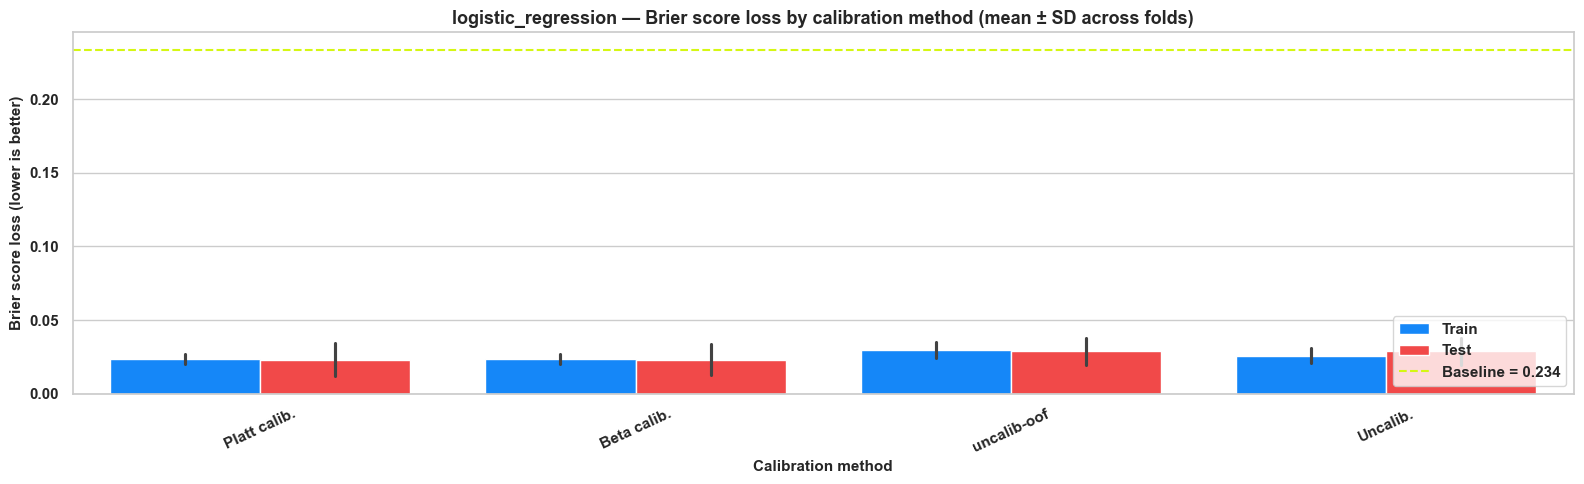

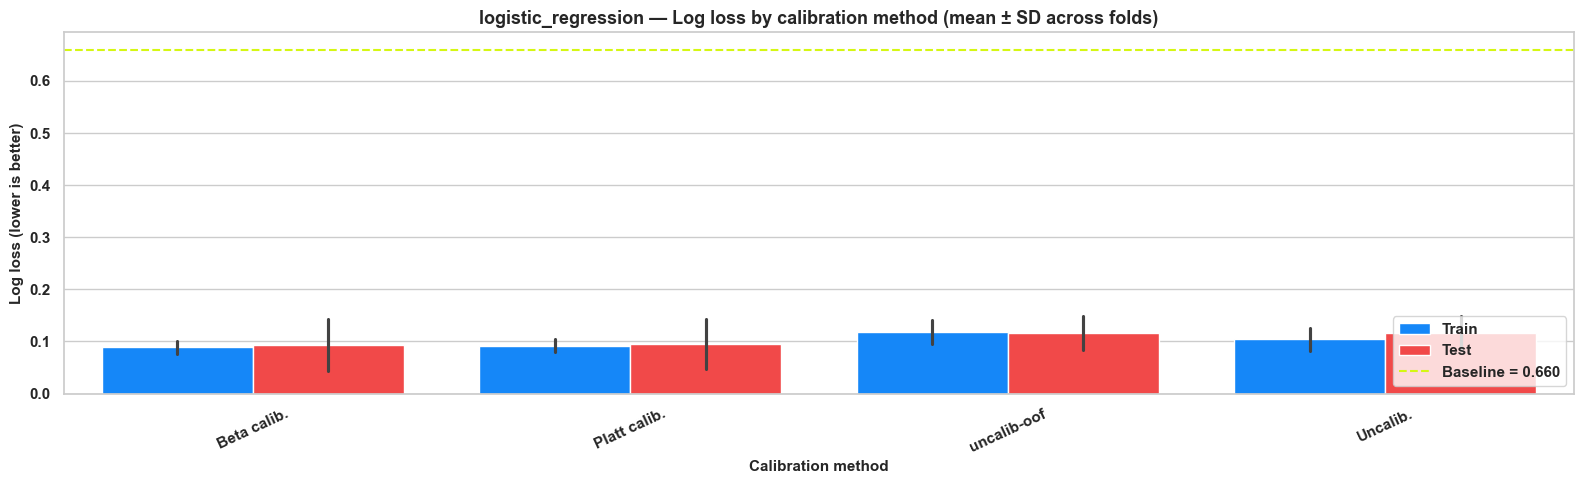

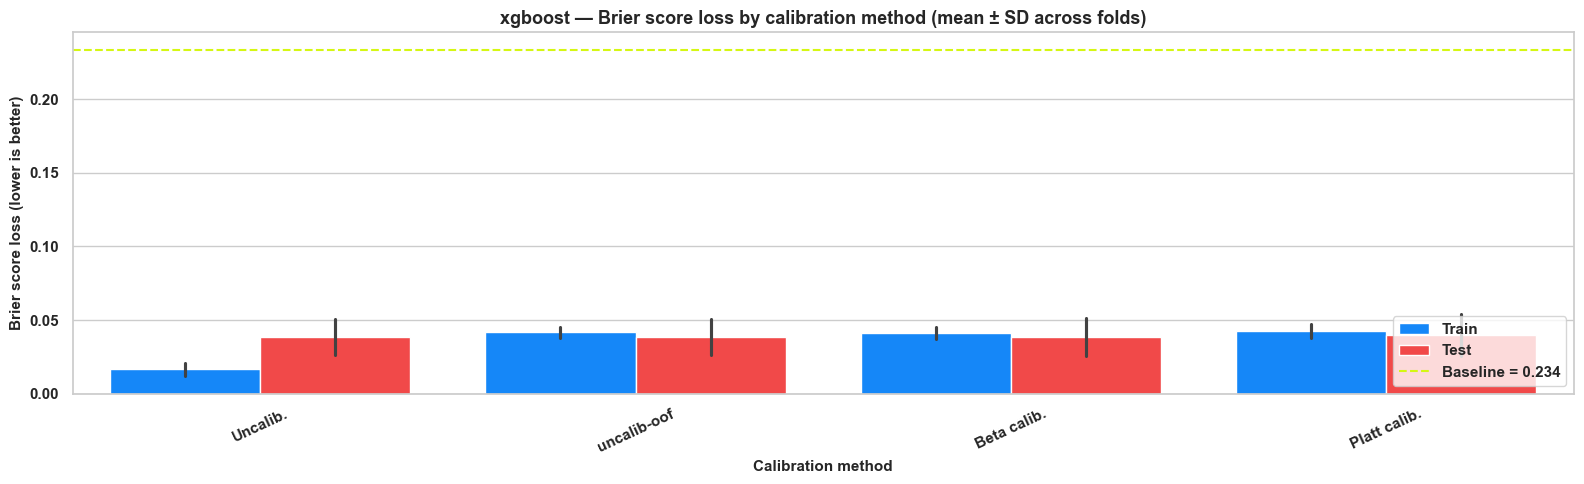

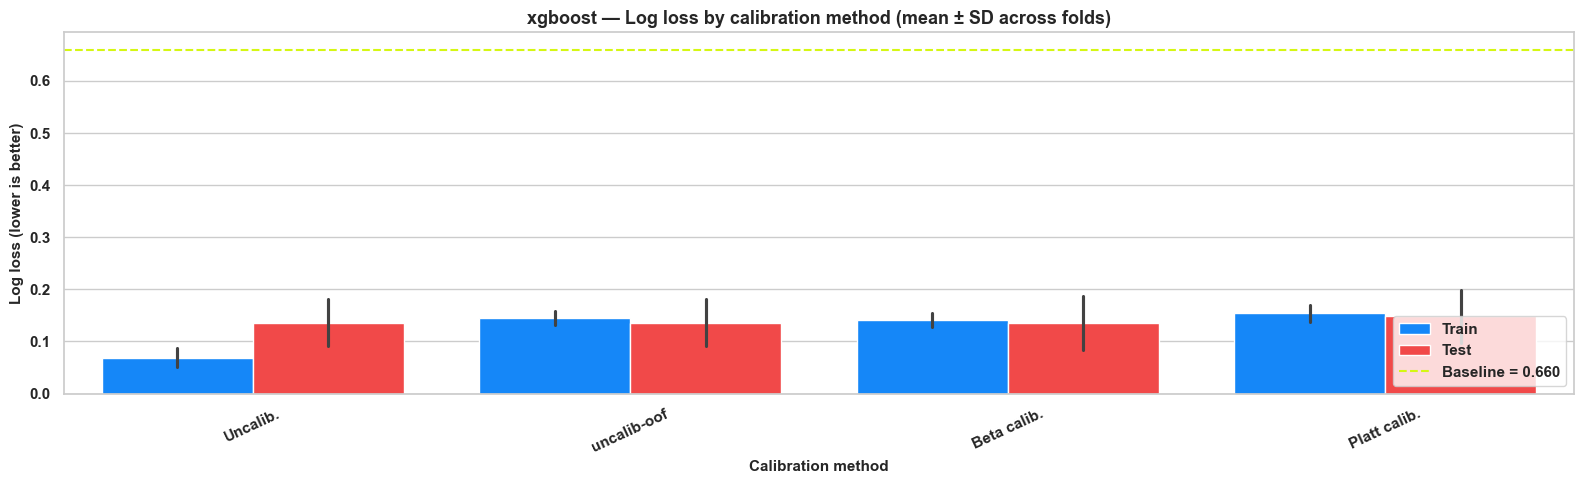

In [13]:

# Organize scores
eval_results = mtci.evaluate_nested_cv_results(
    all_results,
    metrics_to_compute=["average_precision", "roc_auc","brier_score_loss", "log_loss"],
    calibration_methods=["platt", "beta"],
)


alias = {
    "platt": "Platt calib.",
    "beta": "Beta calib.",
    "uncalib_oof": "uncalib-oof",
    "uncalibrated": "Uncalib.",
}

mtci.plot_brier_logloss_all_methods(
    eval_results,
    model_names=None,
    calibration_methods=["platt", "beta"],
    include_uncalibrated=True,
    include_uncalib_oof=True,
    sort_methods_by = "test",
    method_alias=alias,
    split_palette={"Train": "#1587F8", "Test": "#F14949"},
     figsize=(16,5), legend_loc= "lower right", show_prevalence_baseline=True
)

### Compute pooled calibration **intercept (alpha) and slope (beta)** for each model and each calibration method using:

Models:   0%|          | 0/2 [00:00<?, ?it/s]

logistic_regression: methods:   0%|          | 0/3 [00:00<?, ?it/s]

xgboost: methods:   0%|          | 0/3 [00:00<?, ?it/s]


logistic_regression — Slope (β) (sorted by test closeness to ideal=1.0)
------------------------------------------------------------------------------------------
Method                       Train mean±std             Test mean±std              sort(|mean-ideal|)
Platt calib.                 1.0137 ± 0.0253            0.9550 ± 0.0604                    0.0450
Beta calib.                  1.0170 ± 0.0348            0.8930 ± 0.0802                    0.1070
uncalib                      1.8163 ± 0.0655            1.6267 ± 0.1597                    0.6267
------------------------------------------------------------------------------------------


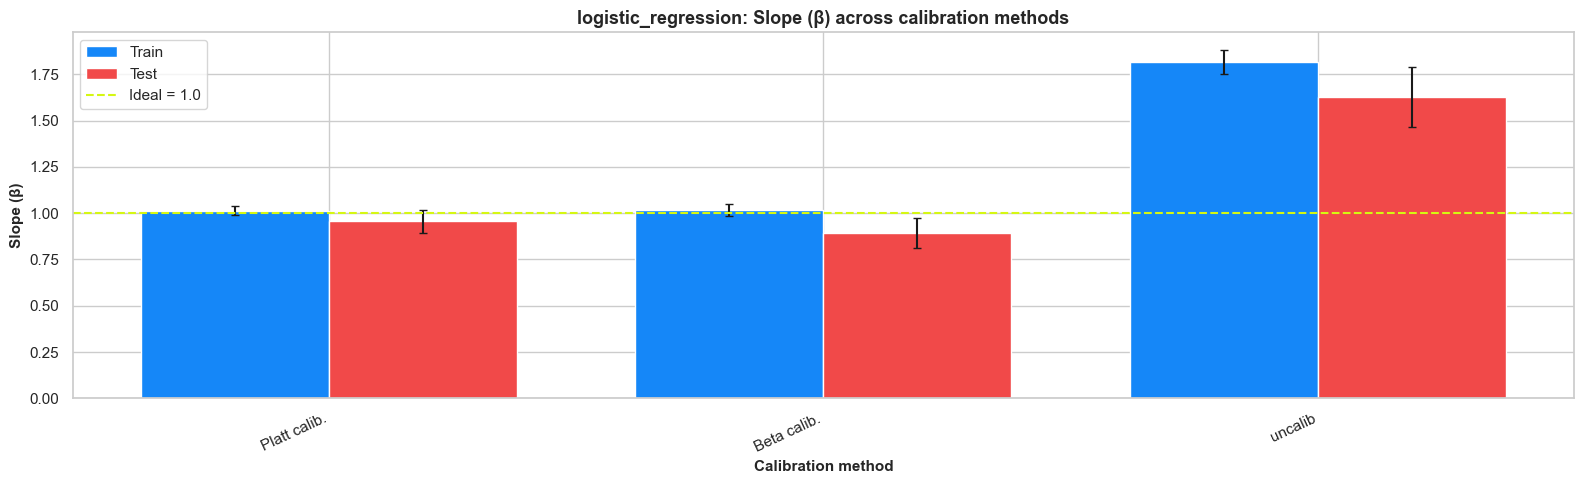


logistic_regression — Intercept (α) (sorted by test closeness to ideal=0.0)
------------------------------------------------------------------------------------------
Method                       Train mean±std             Test mean±std              sort(|mean-ideal|)
Platt calib.                 -0.0363 ± 0.0914           0.0576 ± 0.1841                    0.0576
Beta calib.                  -0.0417 ± 0.0981           0.1551 ± 0.1952                    0.1551
uncalib                      -0.4949 ± 0.0675           -0.3789 ± 0.1504                   0.3789
------------------------------------------------------------------------------------------


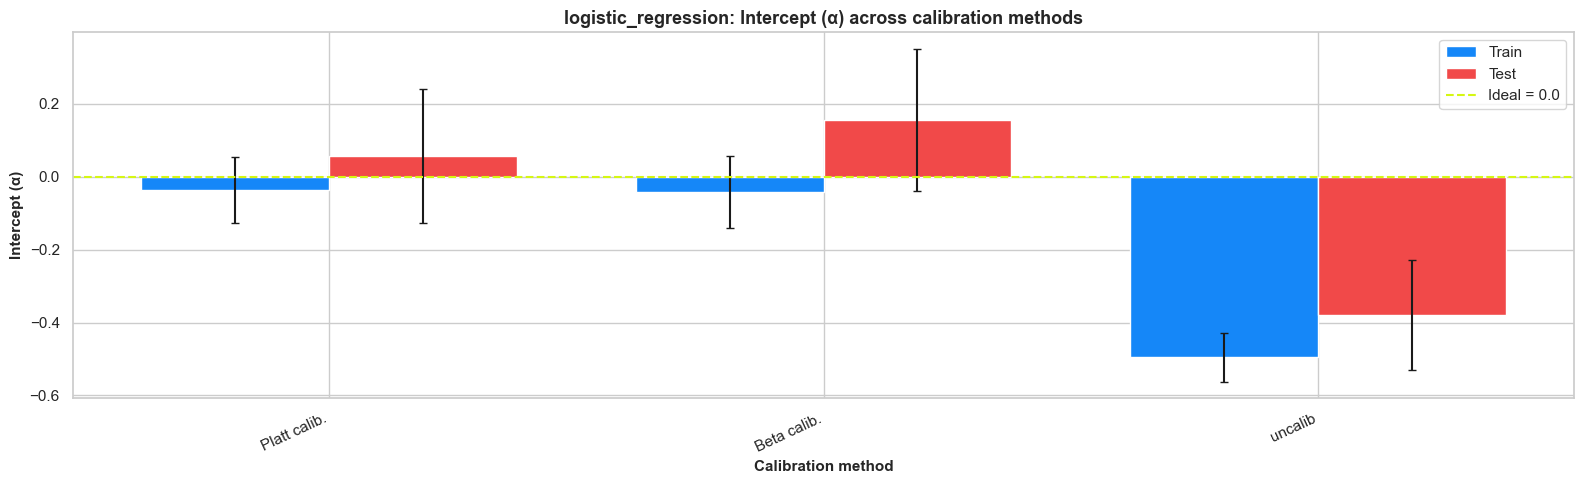


xgboost — Slope (β) (sorted by test closeness to ideal=1.0)
------------------------------------------------------------------------------------------
Method                       Train mean±std             Test mean±std              sort(|mean-ideal|)
Platt calib.                 1.0000 ± 0.0217            1.0011 ± 0.0488                    0.0011
Beta calib.                  1.0030 ± 0.0269            0.9452 ± 0.0684                    0.0548
uncalib                      1.1310 ± 0.0317            1.0816 ± 0.0799                    0.0816
------------------------------------------------------------------------------------------


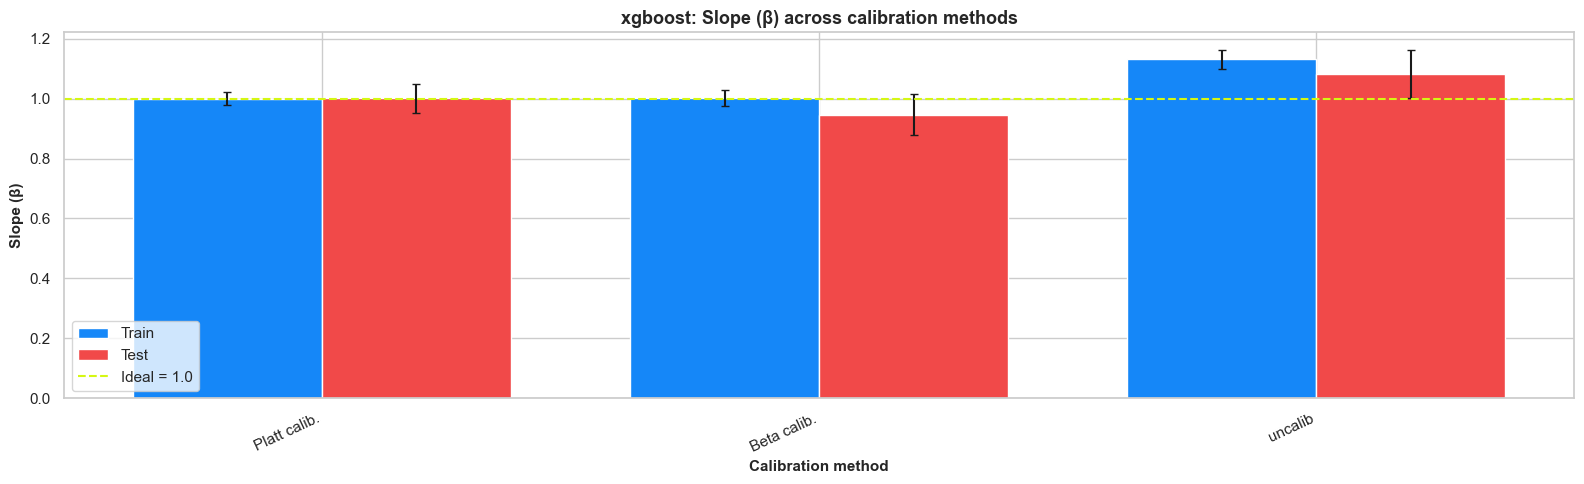


xgboost — Intercept (α) (sorted by test closeness to ideal=0.0)
------------------------------------------------------------------------------------------
Method                       Train mean±std             Test mean±std              sort(|mean-ideal|)
Beta calib.                  -0.0053 ± 0.0679           0.0058 ± 0.1271                    0.0058
Platt calib.                 -0.0048 ± 0.0736           -0.0212 ± 0.1443                   0.0212
uncalib                      -0.1426 ± 0.0645           -0.1530 ± 0.1237                   0.1530
------------------------------------------------------------------------------------------


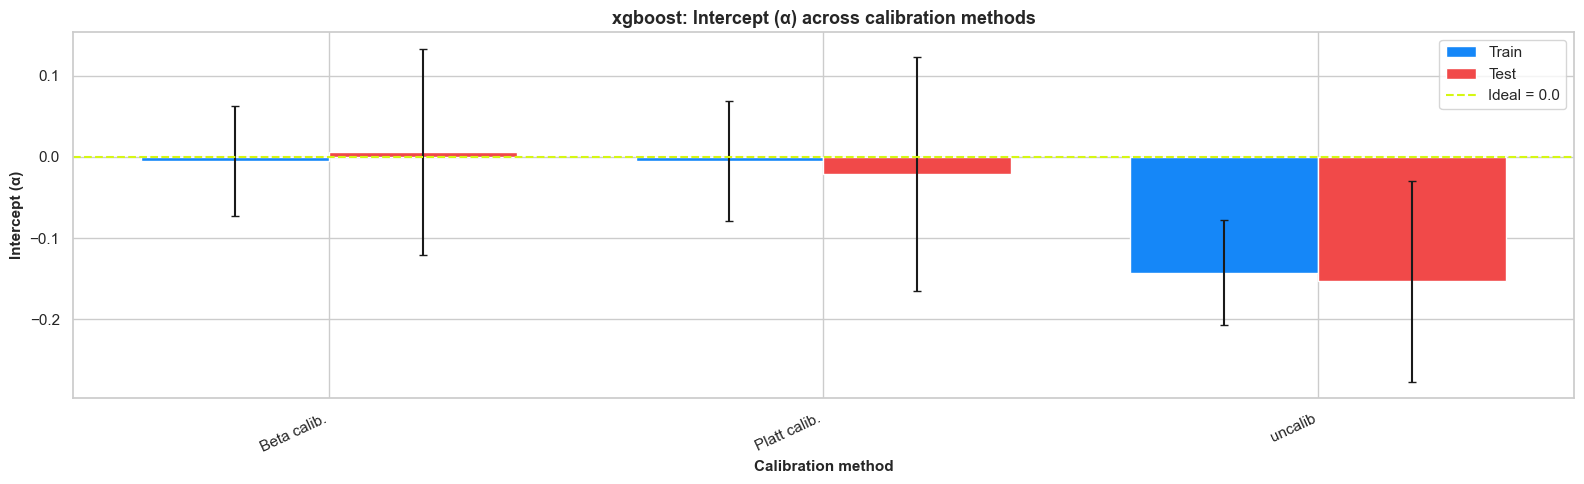

In [14]:
# -------------------------
# Example usage
# -------------------------
calibration_stats = mtci.pooled_bootstrap_calibration_stats_by_model(
    all_results,
    calibration_methods= ["platt", "beta"],  # or None to auto-discover
    n_boot=50, # bootstrap resamples used to estimate mean/std and 95% CI from pooled data
    seed=42,
    eps=1e-12,
)

# Short display names for plotting/table readability (method keys -> concise labels)
alias = {
    "platt": "Platt calib.",
    "beta": "Beta calib.",
    "uncalib_oof": "uncalib-oof",
    "uncalibrated": "Uncalib.",
}

mtci.plot_calibration_param(
    calibration_stats,
    model_name=None,
    methods=None,  # or ["platt", "beta"] + ["uncalibrated","uncalib_oof"]
    method_alias=alias,  # or ["platt", "beta"],+ ["uncalibrated","uncalib_oof"]
    split_palette={"Train": "#1587F8", "Test": "#F14949"},
    sort_by="test",
    figsize=(16, 5),
    font_size=11,
    legend_loc="best",
    show_ideal_line=True,
    ideal_line_color="#D5F713",
    ideal_line_lw=1.5,
    ideal_line_ls="--",
    print_table=True,
    table_decimals=4,
)

## Log loss and brier score: 

Using the user selected calibration method that showed best performance 

 - brier score
 - log loss
 - intercept (alpha)
 - slope (beta)

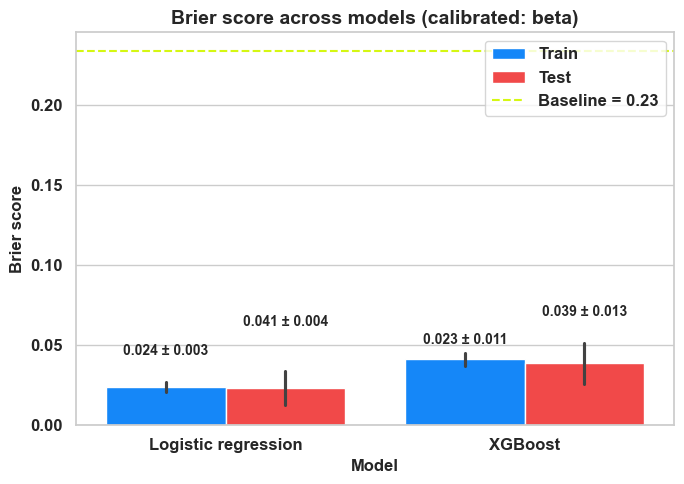

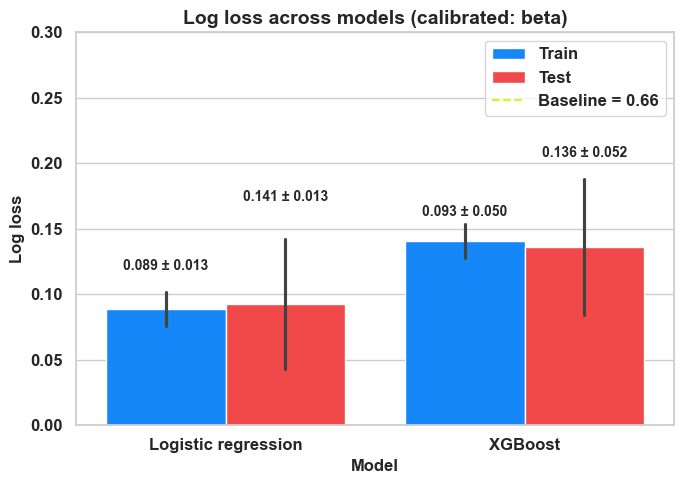

In [15]:

mtci.plot_brier_logloss(
    eval_results,
    model_names= None, # None= use all model with the same calibration
    calibration_method="beta",
    use_calibrated=True,
    include_uncalib_oof=False,
    method_alias={"logistic_regression": "Logistic regression", "xgboost": "XGBoost"},
    split_palette={"Train": "#1587F8", "Test": "#F14949"},
    figsize=(7,5), legend_loc= "upper right", show_prevalence_baseline=True,
    annotate_font_size = 10,
    logloss_ylim=(0, 0.3)  
)




## AUROC and AUPRC barplots

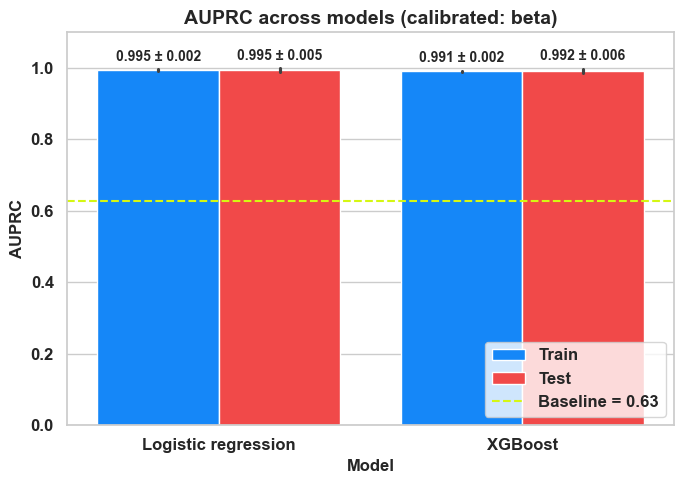

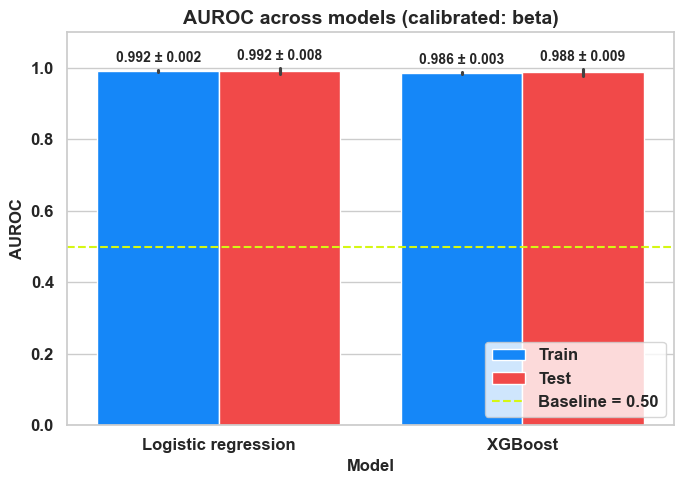

In [16]:

mtci.plot_auprc_auroc(
    eval_results,
    model_names=None,
    calibration_method="beta",
    use_calibrated=True,
    include_uncalib_oof=False,
    method_alias={"logistic_regression": "Logistic regression", "xgboost": "XGBoost"},   # method_alias={"logistic_regression": "Logistic regression", "xgboost": "XGBoost"},
    split_palette={"Train": "#1587F8", "Test": "#F14949"},
    figsize=(7,5), legend_loc= "lower right", show_prevalence_baseline=True,
    annotate_font_size = 10,
    auprc_ylim = (0, 1.1),
    auroc_ylim =(0, 1.1) 
)

## Balanced accuracy

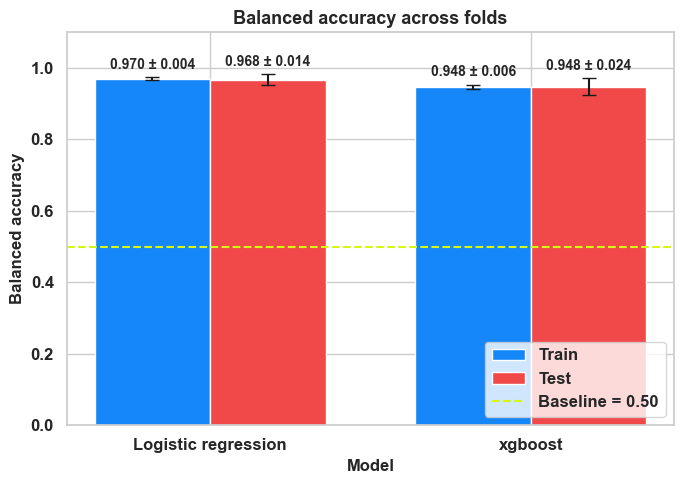

Per-model selected threshold summary (mean ± SD across folds):
  Logistic regression: 0.587 ± 0.116
  xgboost: 0.659 ± 0.091


In [17]:
mtci.barplot_balanced_accuracy(
    all_results,
    model_names=None,
    use_calibrated=True,
    calibration_method="beta",
    mode="train_threshold",  # post-hoc best per split: ['train_threshold', 'test_threshold', 'split_best']
    method_alias={"logistic_regression": "Logistic regression"},
    split_palette={"Train": "#1587F8", "Test": "#F14949"},
    show_baseline=True,
    baseline_color="#D5F713",
    figsize=(7,5),
    legend_loc="lower right",
    annotate_font_size = 10,
    ylim=(0,1.1),
    print_threshold_summary=True
)


## Calibration curve


>>> Generating calibration curve for model: logistic_regression


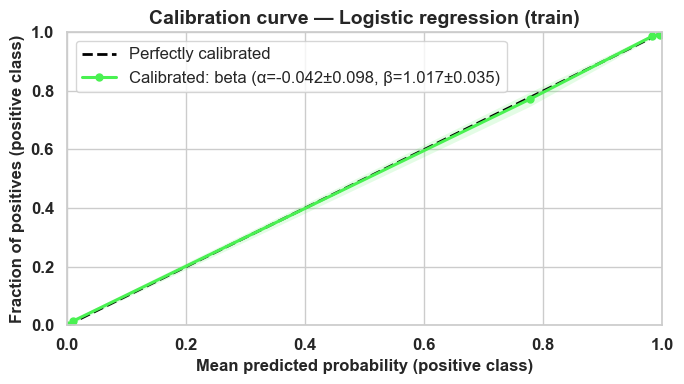

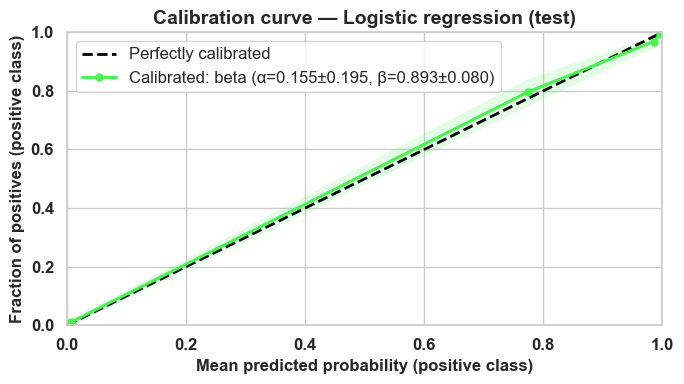

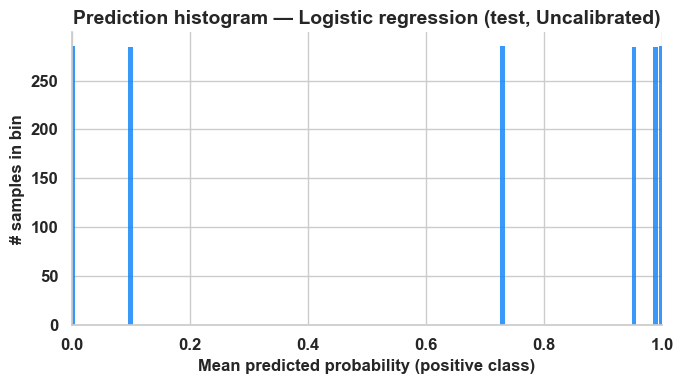

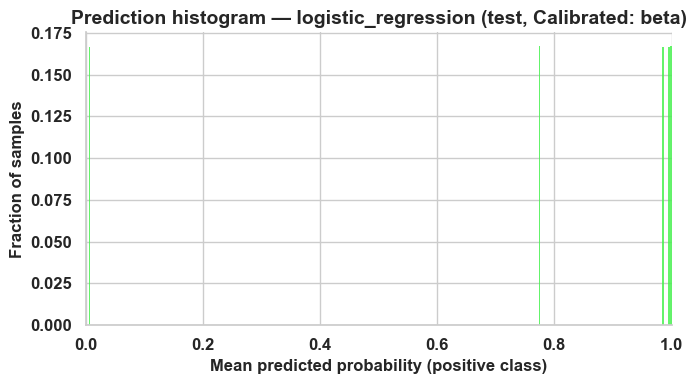


>>> DONE for model: logistic_regression

>>> Generating calibration curve for model: xgboost


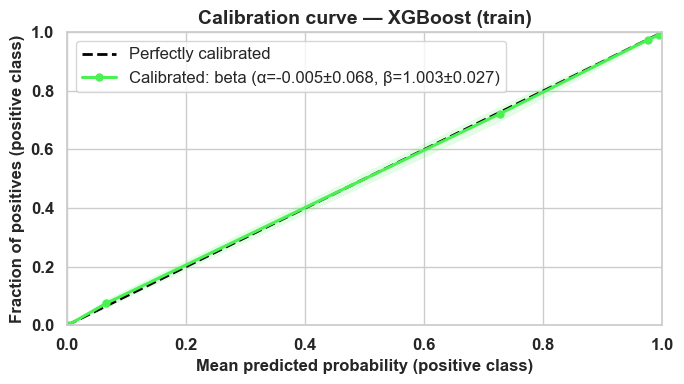

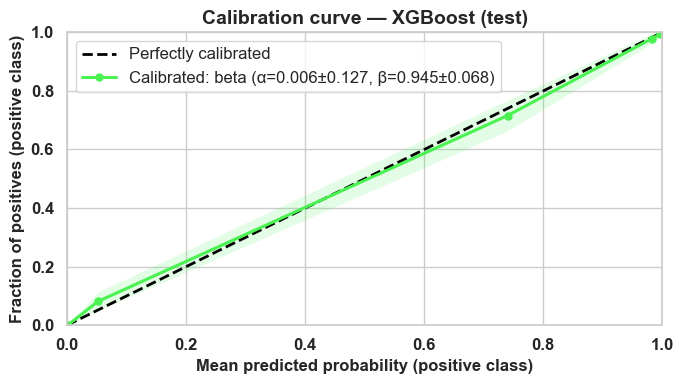

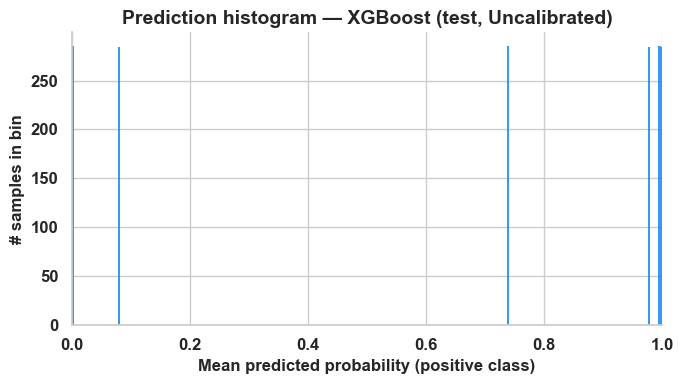

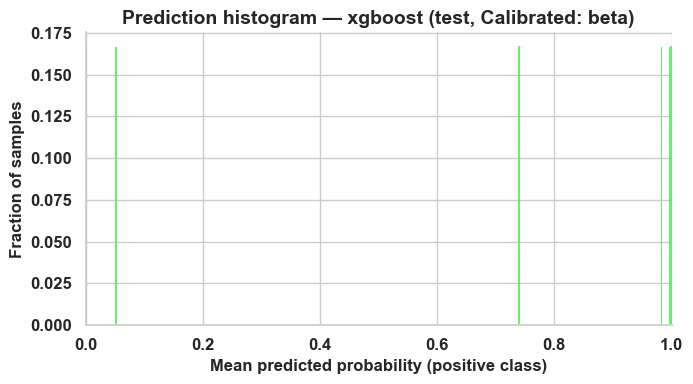


>>> DONE for model: xgboost


In [18]:
figsize=(7, 4)
calibration_methods=[ "beta"]
calibration_method_name = 'beta'

for model_name in ['logistic_regression',  'xgboost']: #'xgboost'

    print(f"\n>>> Generating calibration curve for model: {model_name}")
    print('='*200)
    
    if model_name =="logistic_regression":
        method_alias={"logistic_regression": "Logistic regression"}

    elif model_name =="xgboost":
        method_alias={"xgboost": "XGBoost"}


    # model_name="logistic_regression"
    # figsize=(7, 4)

    calib_data = mtci.extract_calibration_data(
        all_results,
        model_name=model_name,
        calibration_methods=calibration_methods,
    )
    calib_data = mtci.calibration_data_prep(calib_data, n_bins=6, strategy="quantile")

    mtci.plot_calibration_curves(
        calib_data,
        model_name=model_name,
        methods=calibration_methods,
        include_uncalibrated=False,
        figsize=figsize,
        calibration_stats=calibration_stats,
        calibrated_color_map = {calibration_method_name: "#49F151"},
        show_alpha_beta=True,
        alpha_beta_decimals=3,
        method_alias=method_alias,
    )


    mtci.plot_calibration_histogram(
        calib_data,
        model_name=model_name,
        split="test",
        variant="uncalib",
        figsize=figsize,
        method_alias=method_alias,
        uncalib_color="#1587F8",
        calibrated_color_map={calibration_method_name: "#49F151"},
    )

    mtci.plot_calibration_histogram(
        calib_data,
        model_name=model_name,
        split="test",
        variant=calibration_method_name,
        normalize=True,
        figsize=figsize,
        calibrated_color_map={calibration_method_name: "#49F151"},
    )

   
    print(f"\n>>> DONE for model: {model_name}")

    

## Permutation feature importance (nested CV)

This section computes **permutation feature importance** for each model using the **outer test split** from nested cross-validation, then aggregates the results across folds for visualization.

### What permutation importance measures
Permutation importance estimates how much each feature contributes to model performance by:
1. Measuring the model’s baseline score on the test set (using the chosen `scoring` metric).
2. Shuffling one feature column at a time (breaking its relationship with the target).
3. Measuring how much the score drops after shuffling.
4. Repeating the shuffle multiple times (`n_repeats`) to get a stable distribution of importance values.

Larger importance values mean the model’s performance degrades more when that feature is permuted, suggesting the feature is more influential.

### Pipeline steps
We use a convenience pipeline that wraps two steps:

1. **Compute fold-level importances (outer test only)**  
   For each model and each outer fold, compute permutation importance using the already-fitted `final_model` and that fold’s `outer_test_idx`.

2. **Combine across folds**  
   Concatenate the importance repeats from all folds into one matrix per model:
   - `combined_importances[model_name]` has shape `(n_features, total_repeats)`  
   where `total_repeats = n_repeats × (# outer folds)`.

### Key parameters (what to tune)
- `scoring`: metric used to quantify the performance drop (e.g., `"roc_auc"` or `"average_precision"`).
- `n_repeats`: number of shuffles per feature per fold (higher = more stable, slower).
- `n_jobs`: parallelism (`-1` uses all CPU cores).
- `random_state`: controls shuffle reproducibility.

### Output used for plotting
The pipeline returns:
- `all_results` (mutated in-place with per-fold importance matrices)
- `combined_importances` (combined importance matrices used directly by the plotting function)

After this, we typically visualize the **top N features** by mean importance with error bars (std across repeats).


In [25]:
%%time

all_results, combined_importances, model_feature_names = mtci.run_permutation_importance_pipeline(
    all_results=all_results,     # nested-CV results dict (mutated in-place to store fold-level permutation arrays)
    bundle=bundle,               # full dataset bundle (contains X/y arrays + feature_names for slicing)
    cfg=config,                  # config with per-model feature selection: feature_names OR n_features (mirrors training)
    x_key="X_raw",               # use group-aggregated features (rows=groups). Use "X_raw" for sample-level.
    y_key="y",                   # use group-aggregated labels. Use "y" for sample-level.
    scoring="roc_auc",           # metric used to measure performance drop when a feature is permuted ("average_precision" also common)
    n_repeats=1000,               # number of shuffles per feature per fold (higher = more stable, slower)
    random_state=42,             # seed for reproducible shuffling
    n_jobs=-1,                   # parallelism for permutation_importance (-1 uses all cores)
)


Permutation importance pipeline:   0%|          | 0/2 [00:00<?, ?step/s]

logistic_regression: perm imp folds:   0%|          | 0/15 [00:00<?, ?it/s]

xgboost: perm imp folds:   0%|          | 0/15 [00:00<?, ?it/s]

CPU times: total: 15.4 s
Wall time: 23.6 s


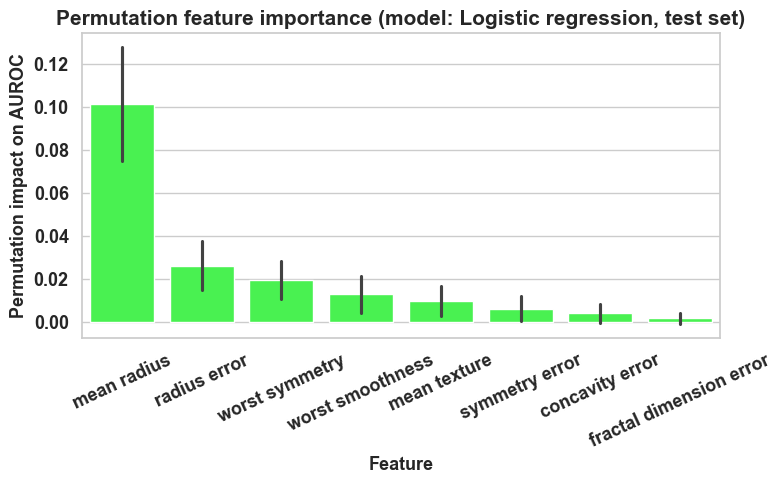

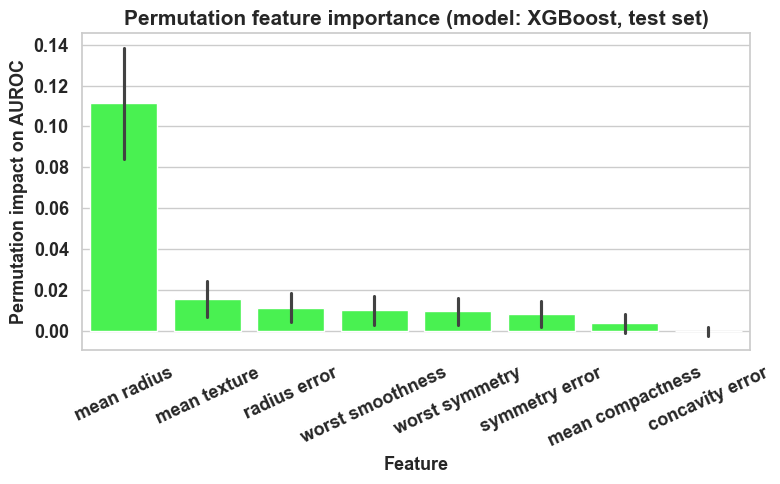

In [27]:

mtci.plot_permutation_importances_barplot(
    combined_importances=combined_importances,   # dict: model_name -> (n_features_model, total_repeats) matrix
    model_name=None,                             # None = plot ALL models; or set "xgboost", "logistic_regression", etc.
    feature_names=model_feature_names,           # dict: {model_name: [feature names used by that model]}
    top_n=15,                                    # show only the top 15 features by mean importance
    scoring="AUROC",                             # label only (computation used scoring="roc_auc" above)
    figsize=(8, 5),                              # figure size
    font_size=13,                                # base font size
    color="#49F151",                             # bar color
    x_tick_rotation=25,                          # rotate x labels for readability
    method_alias={                               # map internal model keys -> display names
        "logistic_regression": "Logistic regression",
    "xgboost": "XGBoost",
    },
)



## Partial dependence plots (PDPs) pipeline 

This section runs the full **Partial Dependence Plot (PDP)** workflow for the *frequency-feature* dataset and then plots the **mean PDP ± 1 std** across outer folds.

### 1) Load the preprocessing/scaler bundle (optional)
We load the saved preprocessing artifacts from disk (typically includes the fitted `StandardScaler` and the full feature order used during training).

- If we pass this `scaler_bundle` into the PDP pipeline, we can add a `grid_value_raw` column (inverse-transformed x-axis values) so PDPs can be plotted in **raw units**.
- If we set `scaler_bundle=None`, we stay entirely in **scaled (z-score) space**.

### 2) Run the PDP pipeline
`run_pdp_pipeline(...)` combines three main steps into one call:

1. **Compute PDPs per outer fold** using the already-fitted `final_model` stored in `all_results`.
   - Handles low-cardinality/binary features by **padding PDP grids with NaNs** internally.
2. **Aggregate PDP points** across folds into a long-format DataFrame per model (`pdp_agg[model_name]`).
3. **Compute mean and std PDP curves** across folds on a common grid (`pdp_agg[f"{model_name}_mean_pdp"]`).
4. *(Optional)* If `scaler_bundle` is provided, add **raw feature units** via `grid_value_raw`.

### 3) Plot mean PDP ± std
Finally, `plot_all_mean_pdp_with_std(...)` plots the **fold-averaged PDP curve** (mean) with a shaded band (± std) for every feature.

Key plotting controls:
- `model_name=None`: plot for all available models (or set a specific model, e.g. `"logistic_regression"`).
- `x_scale="scaled"`: use the standardized x-axis (`grid_value`).  
  Use `x_scale="raw"` only if `grid_value_raw` exists (i.e., if you passed `scaler_bundle`).


✅ Loaded all_results from: C:\Users\neyot\EEG_data\AI_framework\tutorial\tutorial\run_1\breast_cancer\all_features_preproc.pkl.gz


PDP pipeline:   0%|          | 0/4 [00:00<?, ?step/s]


=== Computing PDP for model: logistic_regression ===


logistic_regression folds:   0%|          | 0/15 [00:00<?, ?it/s]


=== Computing PDP for model: xgboost ===


xgboost folds:   0%|          | 0/15 [00:00<?, ?it/s]

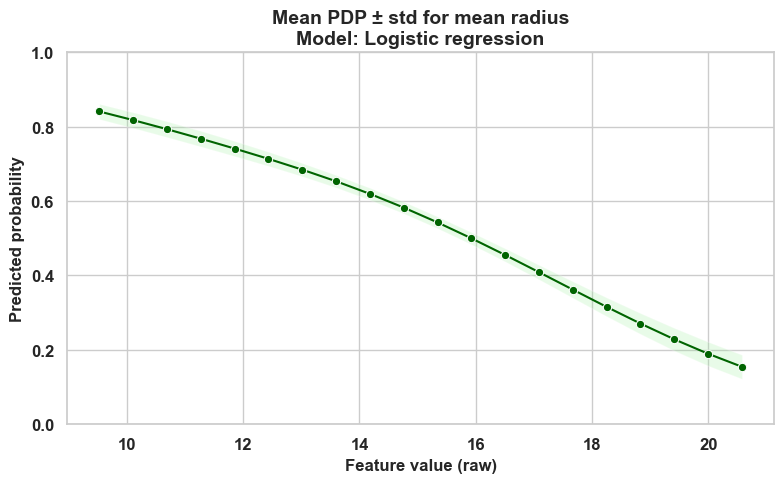

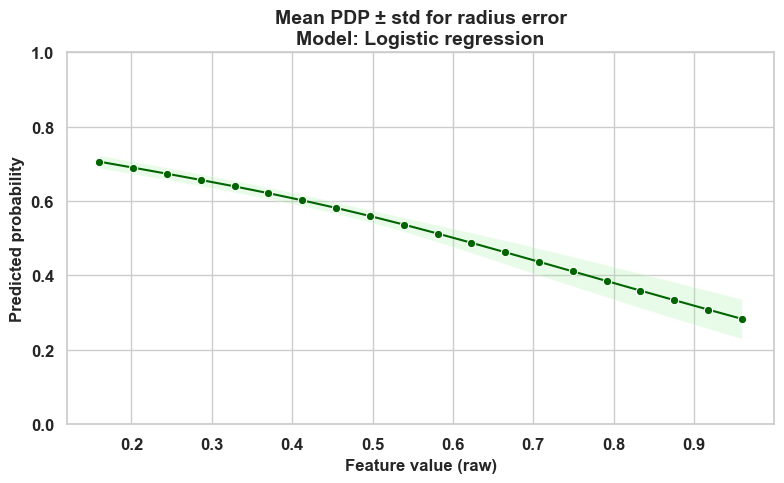

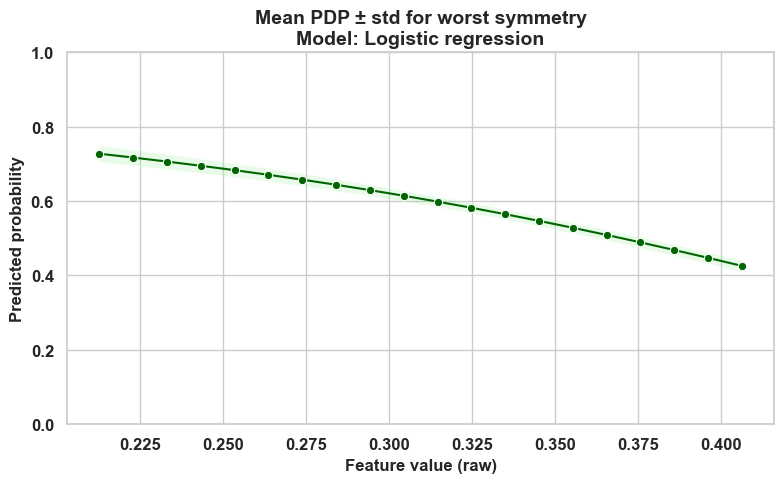

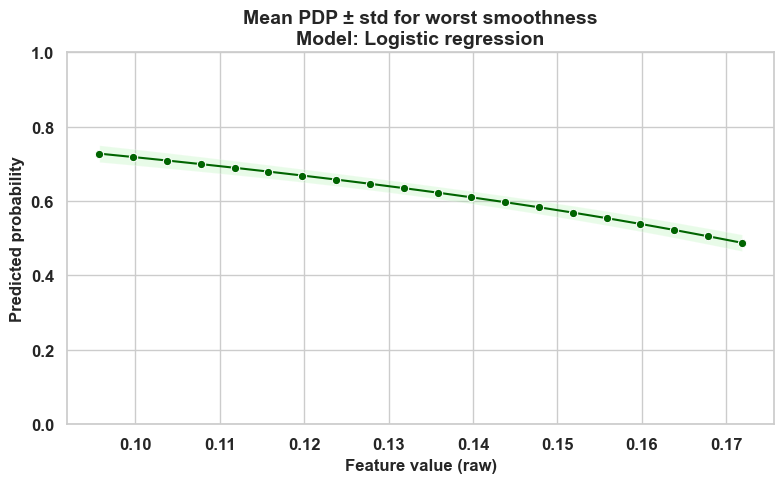

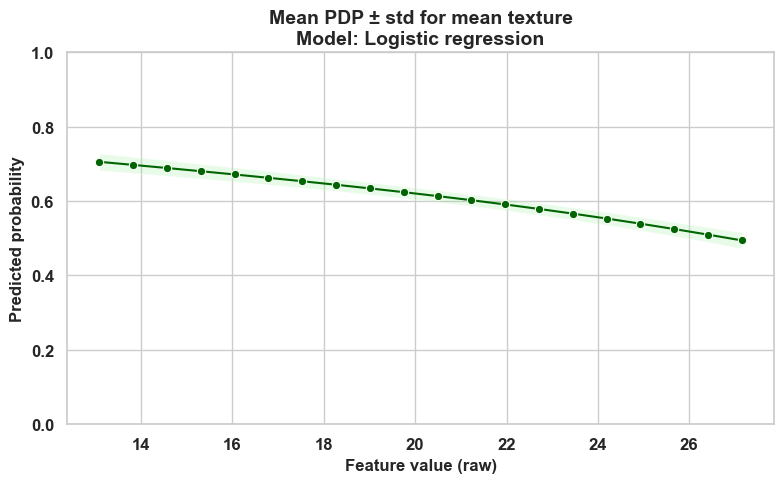

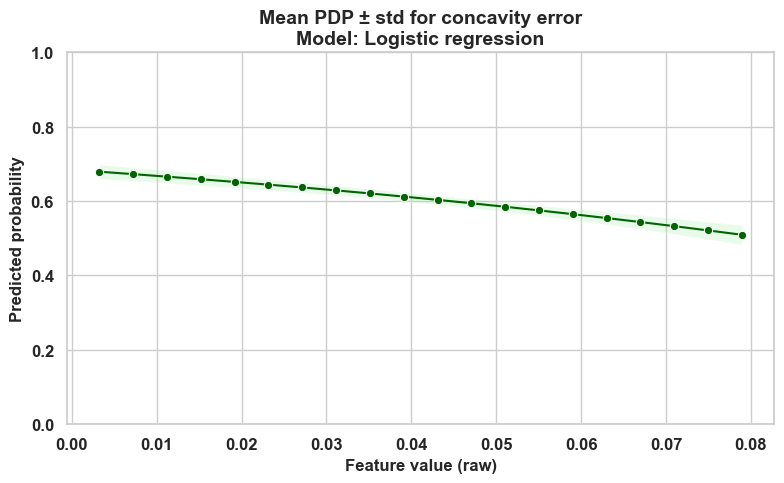

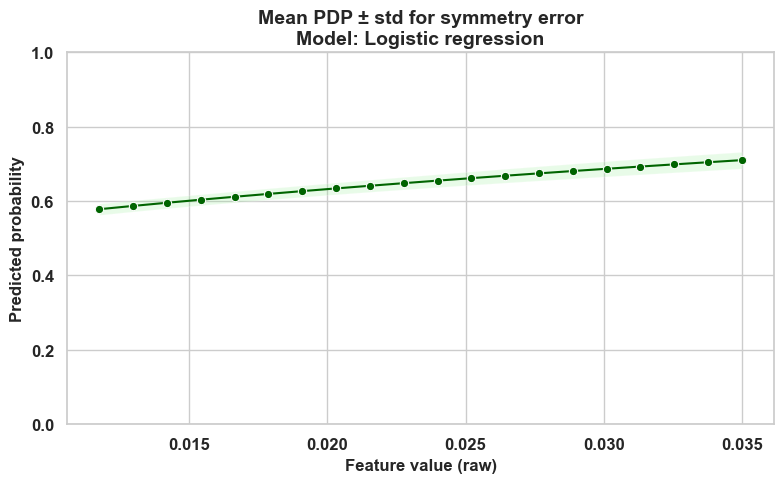

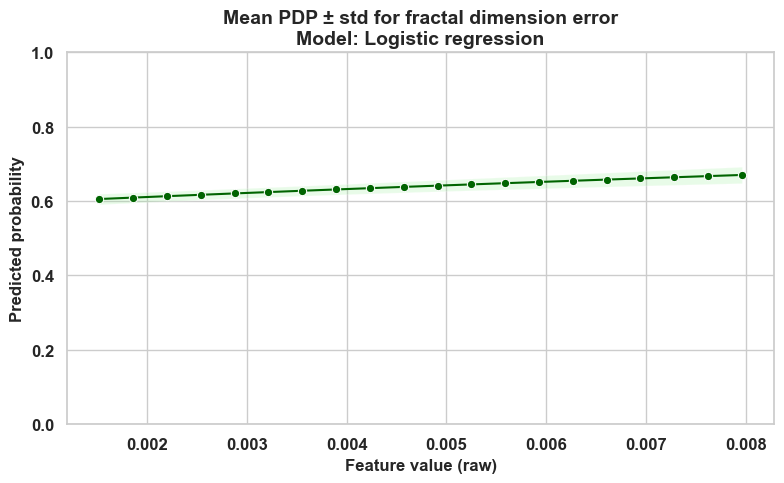

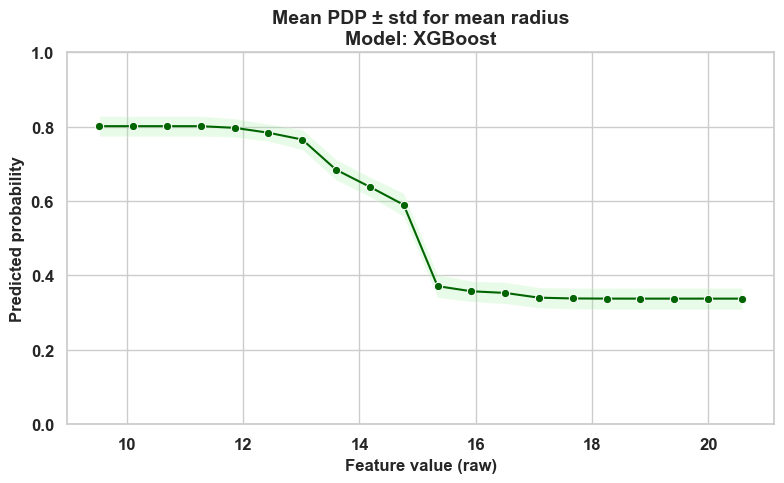

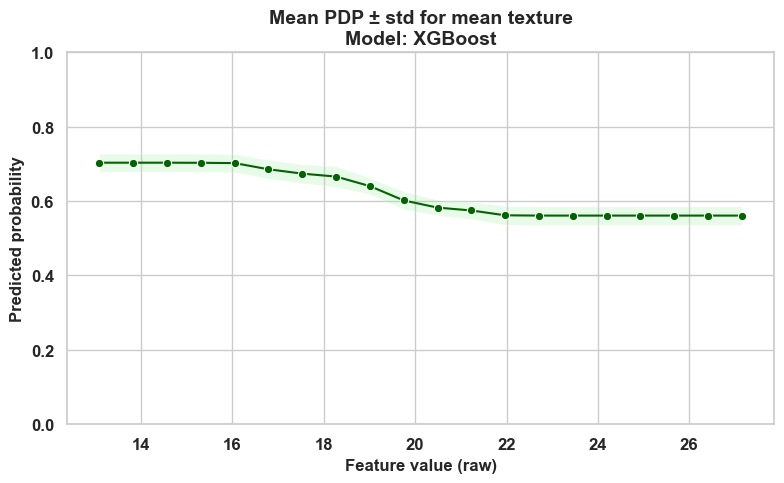

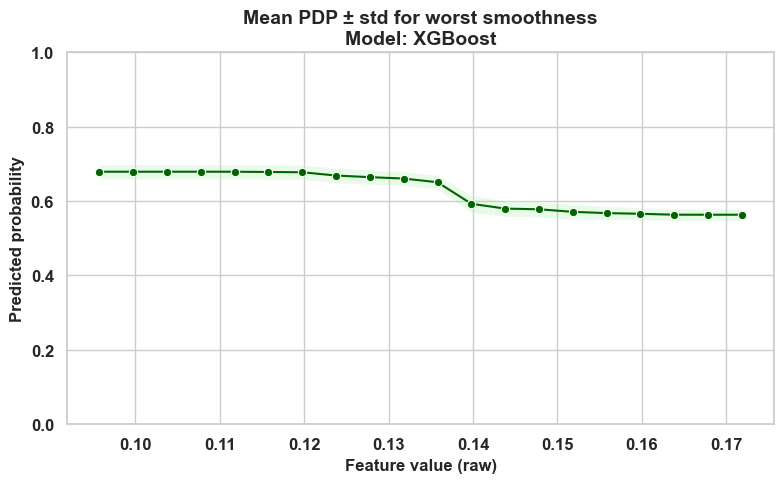

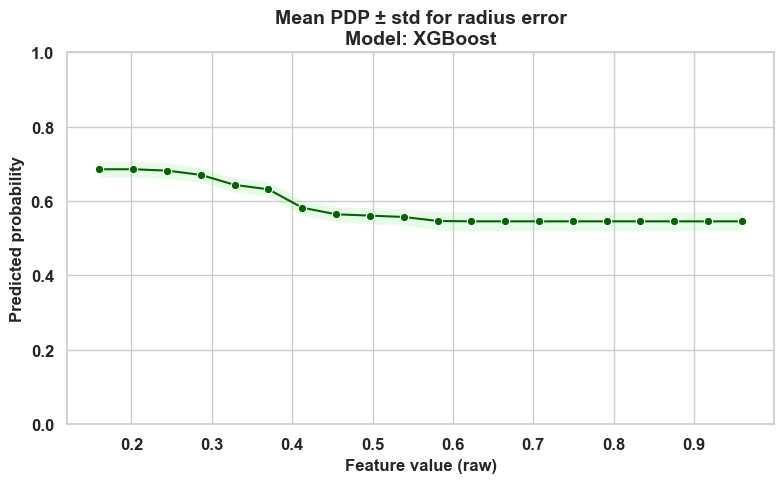

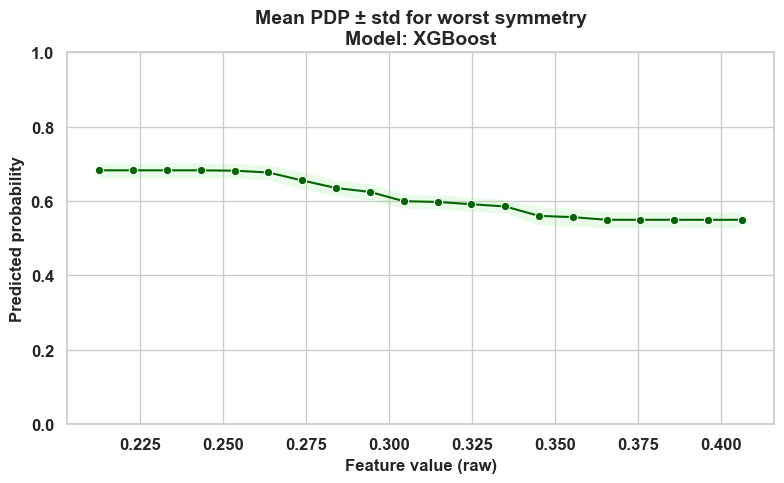

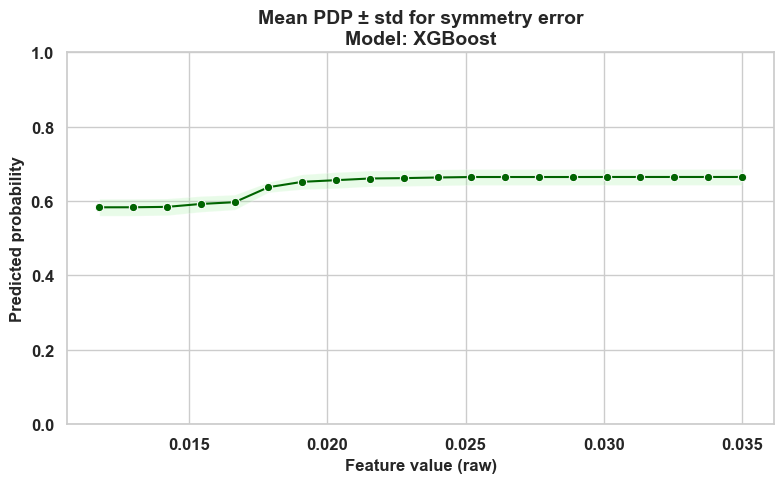

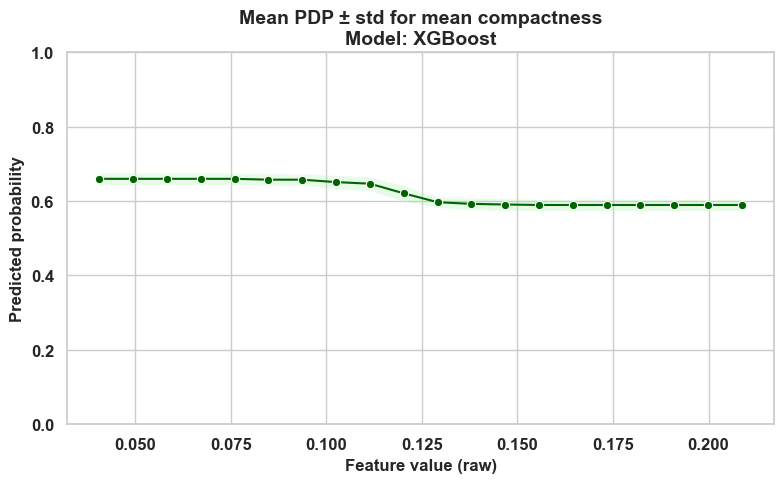

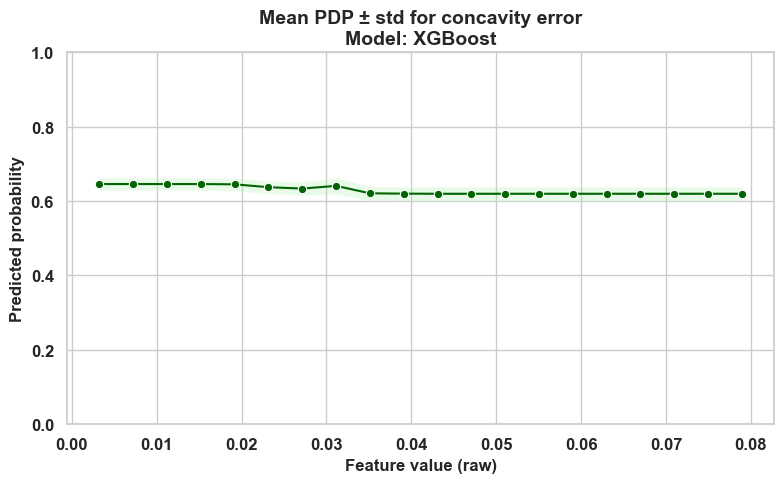

In [ ]:
path = 'tutorial/run_1/breast_cancer'
prefix = 'all_features_preproc'

# Preprocessed features
scaler_bundle = mtci.load_all_results(
    output_dir=path,
    prefix=prefix,
    compress=True,
)


# ------------------------------------------------------------
# 1) Run PDP pipeline (compute per-fold PDPs -> aggregate -> mean/std -> optional raw x-axis)
# ------------------------------------------------------------
all_results, pdp_agg, model_feature_names = mtci.run_pdp_pipeline(
    all_results=all_results,     # nested-CV outputs (dict of folds per model). Mutated in-place to store fold PDP arrays.
    bundle=bundle,               # full dataset bundle (contains X/y arrays + feature_names for slicing)
    cfg=config,                  # config with per-model feature selection: feature_names OR n_features (mirrors training)

    # Which dataset "level" to use from the bundle (must match the indices stored in all_results)
    x_key="X_raw",      # use group-aggregated feature matrix (rows=groups). Use "X_raw" for sample-level.
    y_key="y",          # use group-aggregated labels. Use "y" for sample-level.

    # Which outer split to compute PDPs on
    data_source="test",          # "test" = PDP on outer-test sets only (most honest). "train" or "both" also allowed.

    # How sklearn builds the PDP x-grid per feature (before we later interpolate to a canonical grid)
    grid_resolution=100,         # requested # of grid points for continuous features (discrete features may produce fewer)
    percentiles=(0.0, 1.0),      # x-grid boundaries as percentiles of observed feature values (0..1 = full range)
    centered=False,              # if True, centers PDP curves (changes interpretation; shows deviations from baseline)

    # How we average curves across folds (canonical grid for mean/std)
    n_points=20,                 # number of points in canonical grid for continuous features (bigger => smoother mean curve)
    discrete_threshold=10,       # if a feature has <= this many unique values, treat as discrete (use unique values grid)

    # Optional: add grid_value_raw so plots can show raw units instead of scaled units
    scaler_bundle=scaler_bundle, # contains info to map scaled grid values back to raw units (if None, skip raw conversion)
)


# ------------------------------------------------------------
# 2) Plot mean PDP ± std for every feature (one figure per feature per model)
# ------------------------------------------------------------
mtci.plot_all_mean_pdp_with_std(
    pdp_agg,                         # output dict from pipeline containing per-model mean/std tables

    # Which models to plot
    model_name=None,                 # None = plot ALL models in pdp_agg; or set "xgboost", "logistic_regression", etc.

    # Feature naming (important now that each model can have different feature sets)
    feature_names=model_feature_names,  # dict: {model_name: [feature names used by that model]} (like perm-importance barplot)

    # Which x-axis to use
    x_scale="raw",                   # "raw" uses grid_value_raw (requires scaler_bundle step ran); "scaled" uses grid_value

    # Plot formatting
    figsize=(8, 5),                  # size of each feature plot
    font_size=12,                    # base font size for labels/ticks/titles
    y_lim=(0.0, 1.0),                # optional fixed y-axis bounds (useful for probability outputs)
    line_color="darkgreen",          # PDP mean line color
    fill_color="lightgreen",         # color for the ±std shaded band
    sns_style="whitegrid",           # seaborn styling preset
    fill_alpha=0.2,                  # transparency for shaded band
    fill_edgecolor=None,             # edge outline for shaded band (None = no outline)

    # Optional: nicer names in titles
    method_alias={                   # map internal model keys -> display names used in plot titles
        "logistic_regression": "Logistic regression",
        "xgboost": "XGBoost",
    },
)


## Risk distribution plots (across all CV trials)

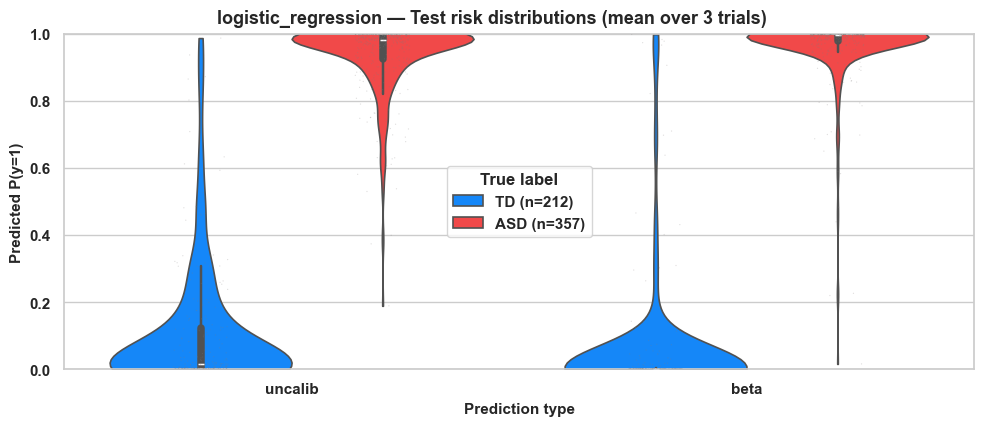

In [19]:

df_long = mtci.build_long_predictions_df(
    all_results,
    model_name=None,
    methods=["beta"],
    groups_all = None,
    group_id_to_key=None,
    include_uncalibrated=True,
    include_test=True,
    include_train_oof=False,   # keep off for now
    unit_col="idx"
)



df_agg_test = mtci.plot_risk_distributions_by_outcome(
    df_long,
    model_name="logistic_regression",
    split="test",
    variants=["uncalib", "beta"],
    value_col="p_mean",
    outcome_palette={"0 (neg)":  "#1587F8", "1 (pos)": "#F14949"},
    jitter_palette={"0 (neg)": "#817D7D", "1 (pos)": "#817D7D"},
    point_alpha=0.25,
    point_size=0.9,
    jitter=0.12,
    prevalence=False,
    outcome_legend_alias={"0 (neg)": "TD", "1 (pos)": "ASD"},
    figsize=(10,5),
)



## Pooled patient risk summary: **"all_trials"**
- all_trials:      ["model","variant","split","group"]

    Pools window-level predictions for a patient across ALL CV runs (trial × outer_fold).
    
    Interpretation: for each patient, pool *all* out-of-sample window-level predictions across all runs, then compute a single patient-level center + spread.

    Note: default assumes you did `StratifiedGroupkfold` hence "group" in all_trials. If not, use unit_col='idx' for `Stratifiedkfold`

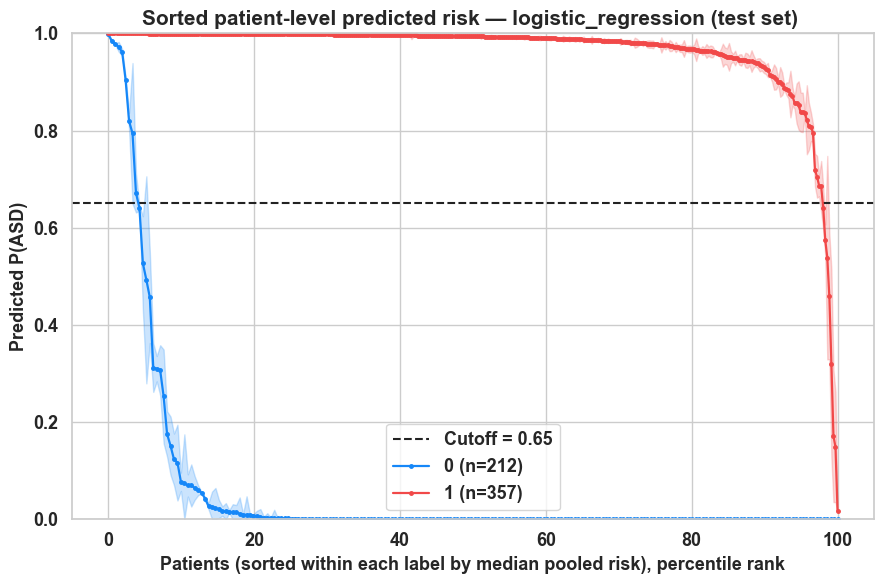

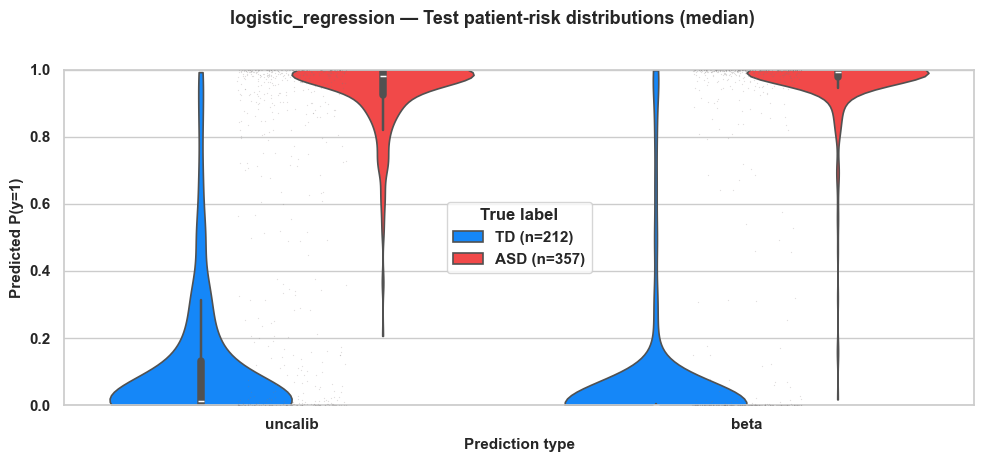

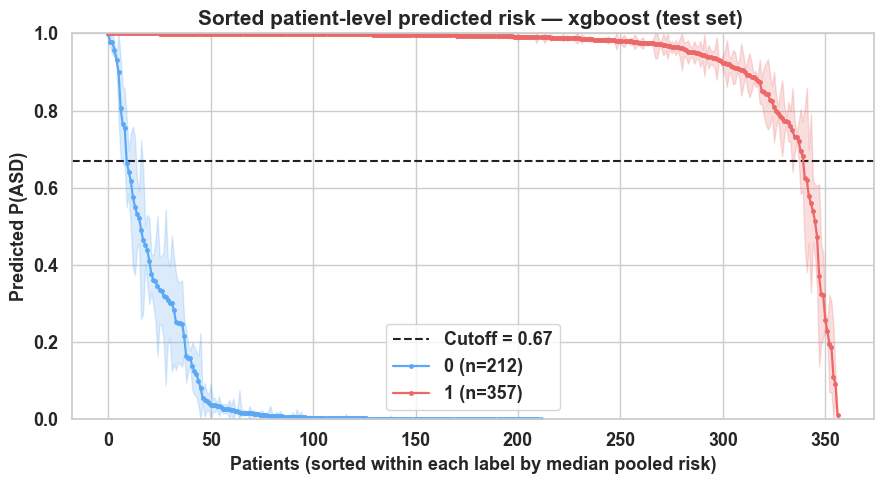

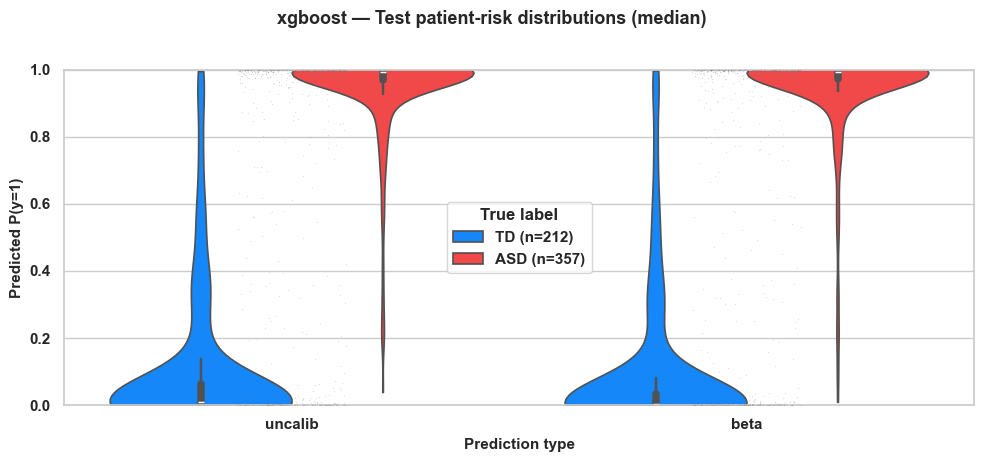

In [23]:
df_pat = mtci.pooled_patient_risk_summary(
    df_long,
    grouping=None,
    unit_col="idx",
    agg="median",
    lower_q=0.0,
    upper_q=1.0,
    include_test=True,
    include_train_oof=False,
)



out_pat = mtci.plot_ranked_patients_patient_level(
    df_pat,
    model="logistic_regression",
    variants=[ "beta"],
    colors=["#1587F8", "#F14949"],   # ASD, TD (in the order group_label is detected/sorted)
    split="test",
    group_label=None,               # auto-detect (e.g., ASD + TD)
    center_col="p_median",
    std_col="p_total_std",
    prob_label="ASD",
    show_prevalence_baseline=False,
    make_overlay=True,
    make_separate=False,
    font_size=13,
    figsize_overlay=(9, 6),
    figsize_single=(8, 4),
    show_cutoff_lines=True,
    cutoffs = 0.65, 
    cutoff_color = "#222222",
    cutoff_lw = 1.5,
    cutoff_ls = "--",
    cutoff_labels = True,                       # whether to add legend labels
    cutoff_label_fmt = "Cutoff = {c:.2f}",
    x_mode='percentile', # or 'index', 'percentile'
)




_ = mtci.plot_patient_risk_distributions_by_outcome(
    df_pat,
    model_name="logistic_regression",
    split="test",
    variants=["uncalib", "beta"],
    value_col="p_median",
    unit_col="idx",  # or "idx" in the single-row-per-patient world
    outcome_palette={"0 (neg)":  "#1587F8", "1 (pos)": "#F14949"},
    jitter_palette={"0 (neg)": "#817D7D", "1 (pos)": "#817D7D"},
    prevalence=False,
    outcome_legend_alias={"0 (neg)": "TD", "1 (pos)": "ASD"},
)



out_pat_xgb = mtci.plot_ranked_patients_patient_level(
    df_pat,
    model="xgboost",
    variants=[ "beta"],
    colors=["#5BA8F5", "#EC6868"],   # ASD, TD (in the order group_label is detected/sorted)
    split="test",
    group_label=None,               # auto-detect (e.g., ASD + TD)
    center_col="p_median",
    std_col="p_total_std",
    prob_label="ASD",
    show_prevalence_baseline=False,
    make_overlay=True,
    make_separate=False,
    font_size=13,
    figsize_overlay=(9, 5),
    figsize_single=(8, 4),
    show_cutoff_lines=True,
    cutoffs = 0.67, 
    cutoff_color = "#222222",
    cutoff_lw = 1.5,
    cutoff_ls = "--",
    cutoff_labels = True,                       # whether to add legend labels
    cutoff_label_fmt = "Cutoff = {c:.2f}",
    x_mode='index', # or 'index', 'percentile'
)


_ = mtci.plot_patient_risk_distributions_by_outcome(
    df_pat,
    model_name="xgboost",
    split="test",
    variants=["uncalib", "beta"],
    value_col="p_median",
    unit_col="idx",  # or "idx" in the single-row-per-patient world
    outcome_palette={"0 (neg)":  "#1587F8", "1 (pos)": "#F14949"},
    jitter_palette={"0 (neg)": "#817D7D", "1 (pos)": "#817D7D"},
    prevalence=False,
    outcome_legend_alias={"0 (neg)": "TD", "1 (pos)": "ASD"},
)


## Local “Pocket” Analysis: `pocket_metrics_by_model`

`pocket_metrics_by_model` implements a **model-guided cohort stratification** step to quantify *high-confidence regions* in patient-level predictions. The goal is to move beyond a single global performance number and instead measure whether there are **subsets of patients (“pockets”)** where EEG-based predictions are relatively reliable.

### What it does (conceptually)

1) **Starts from patient-level predictions (one row per subject)**  
   The input dataframe contains subject-level scores (e.g., `p_median`) representing the model’s predicted probability for the **positive class** (ASD). These are already aggregated per subject (not window-level).

2) **Applies a “pocket” rule based on model confidence**  
   Using a probability threshold (or score band), it defines a **high-confidence pocket**:
   - Example: `p >= 0.67` selects subjects the model considers ASD-likely with high confidence.


### Why this is useful (use case for EEG)
Clinical EEG classification performance is often modest at the population level. This function supports the hypothesis that **EEG separability is heterogeneous**: there may exist subsets of individuals for whom EEG provides stronger, more consistent discriminative signal. Identifying and quantifying these pockets enables **focused follow-up analyses** and motivates **enrichment strategies** for future studies (e.g., prioritizing EEG-separable individuals for deeper phenotyping or prospective validation).


model variant split score_col  thr_low  thr_high pos_label  \
0  logistic_regression    beta  test  p_median      0.8       1.0         1   

  neg_label  n_selected  n_total  pct_selected  n_pos_selected  \
0         0         351      569      0.616872             344   

   n_neg_selected       ppv       fdr  pos_to_neg_ratio  baseline_prevalence  \
0               7  0.980057  0.019943         49.142857             0.627417   

   enrichment_factor  
0           1.562052

model variant split score_col  thr_low  thr_high pos_label neg_label  \
0  xgboost    beta  test  p_median      0.8       1.0         1         0   

   n_selected  n_total  pct_selected  n_pos_selected  n_neg_selected  \
0         333      569      0.585237             326               7   

        ppv       fdr  pos_to_neg_ratio  baseline_prevalence  \
0  0.978979  0.021021         46.571429             0.627417   

   enrichment_factor  
0           1.560333

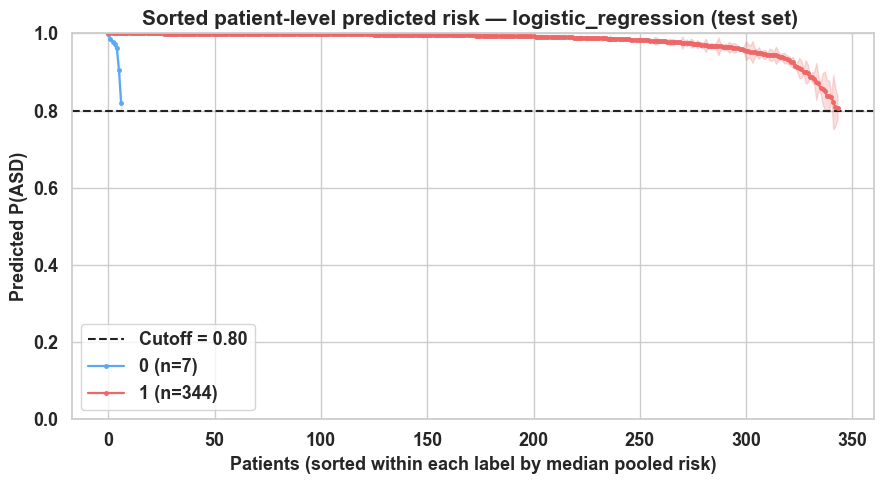

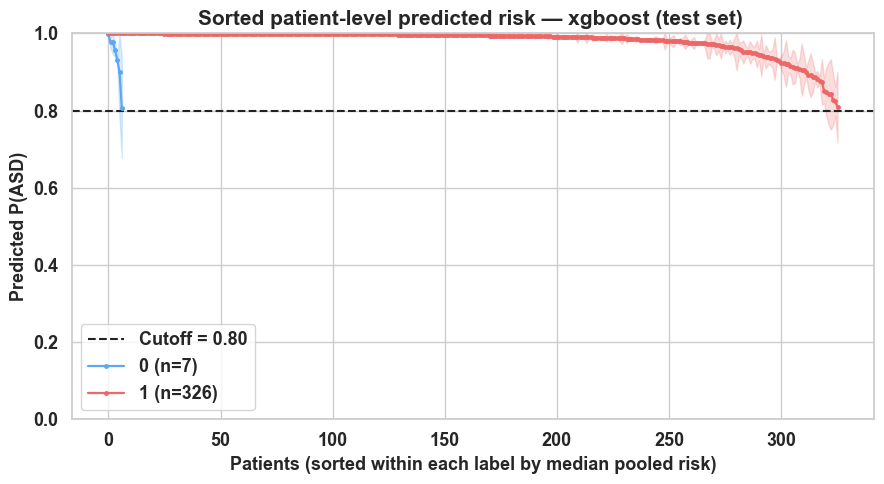

In [38]:



threshold=0.80

out = post.pocket_metrics_by_model(
    df=df_pat,
    model=None,
    threshold=threshold,
    variants="beta",
    split="test",
    meta_cols=["model", "variant", "split"],
    subject_col="idx",
)

summary_lr, df_hi_lr = out["logistic_regression"]
summary_xgb, df_hi_xgb = out["xgboost"]
display(summary_lr)
display(summary_xgb)


_ = mtci.plot_ranked_patients_patient_level(
    df_hi_lr,
    model='logistic_regression',
    variants=[ "beta"],
    colors=["#5BA8F5", "#EC6868"],   # ASD, TD (in the order group_label is detected/sorted)
    split="test",
    group_label=None,               # auto-detect (e.g., ASD + TD)
    center_col="p_median",
    std_col="p_total_std",
    prob_label="ASD",
    show_prevalence_baseline=False,
    make_overlay=True,
    make_separate=False,
    font_size=13,
    figsize_overlay=(9, 5),
    figsize_single=(8, 4),
    show_cutoff_lines=True,
    cutoffs = threshold, 
    cutoff_color = "#222222",
    cutoff_lw = 1.5,
    cutoff_ls = "--",
    cutoff_labels = True,                       # whether to add legend labels
    cutoff_label_fmt = "Cutoff = {c:.2f}",
    x_mode='index', # or 'index', 'percentile'
)


_ = mtci.plot_ranked_patients_patient_level(
    df_hi_xgb,
    model='xgboost',
    variants=[ "beta"],
    colors=["#5BA8F5", "#EC6868"],   # ASD, TD (in the order group_label is detected/sorted)
    split="test",
    group_label=None,               # auto-detect (e.g., ASD + TD)
    center_col="p_median",
    std_col="p_total_std",
    prob_label="ASD",
    show_prevalence_baseline=False,
    make_overlay=True,
    make_separate=False,
    font_size=13,
    figsize_overlay=(9, 5),
    figsize_single=(8, 4),
    show_cutoff_lines=True,
    cutoffs = threshold, 
    cutoff_color = "#222222",
    cutoff_lw = 1.5,
    cutoff_ls = "--",
    cutoff_labels = True,                       # whether to add legend labels
    cutoff_label_fmt = "Cutoff = {c:.2f}",
    x_mode='index', # or 'index', 'percentile'
)


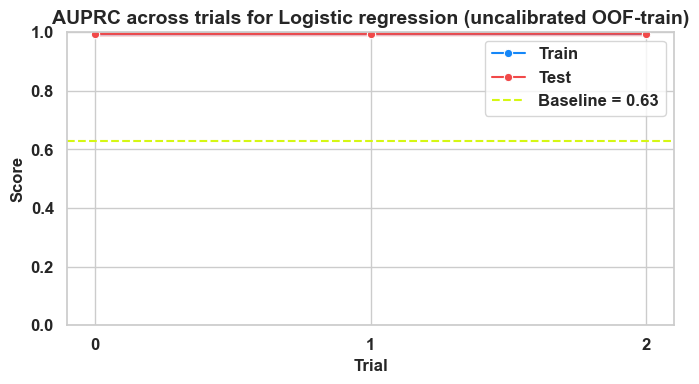

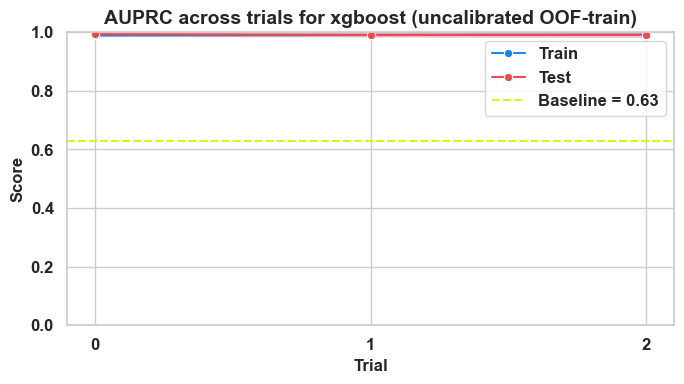

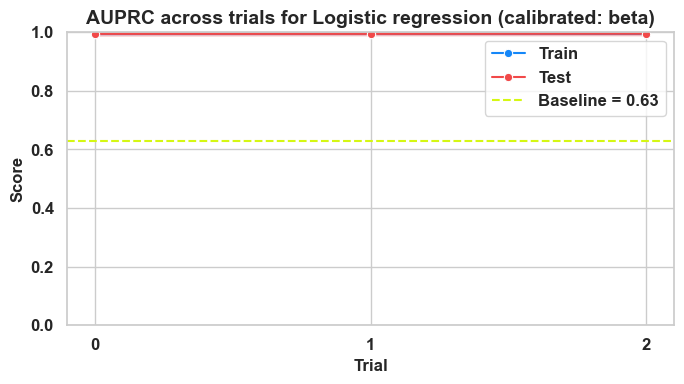

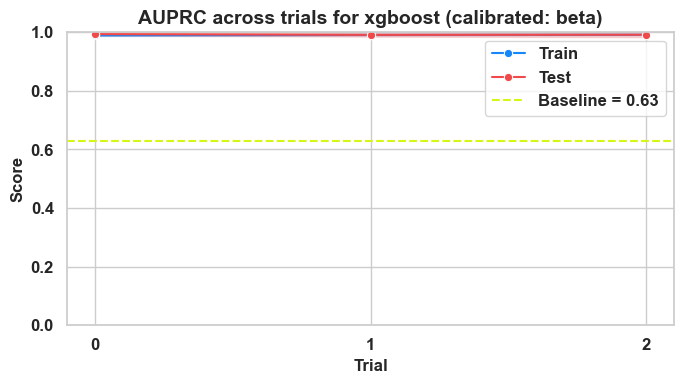

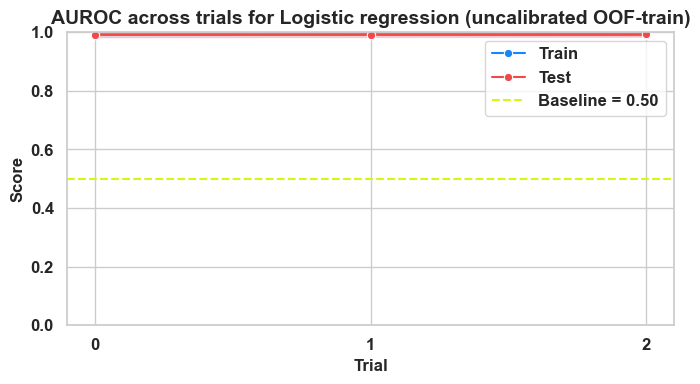

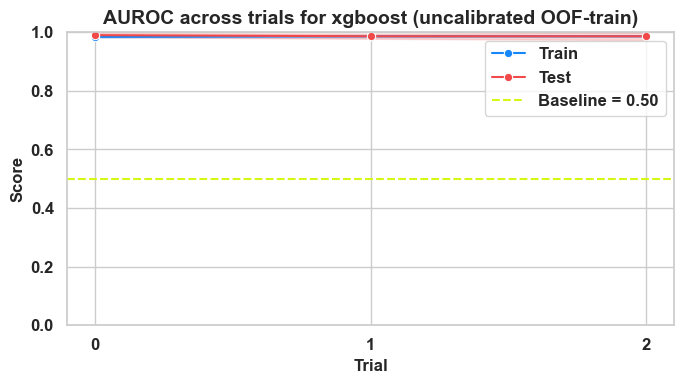

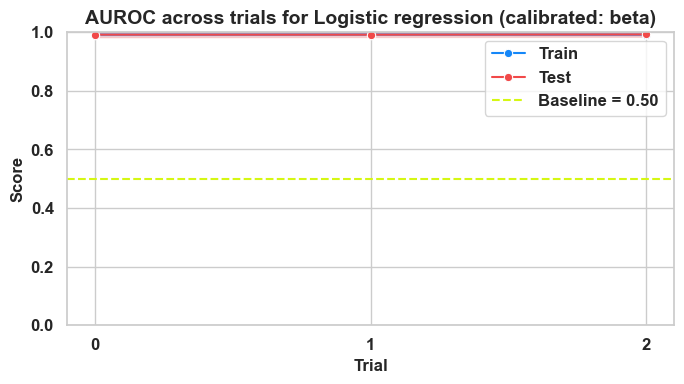

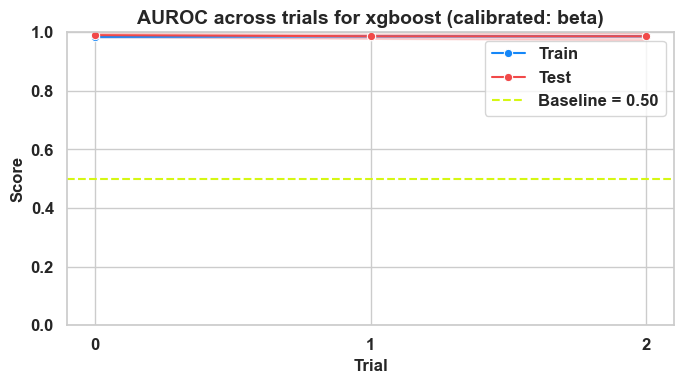

In [29]:

mtci.plot_metric_over_trials(
    eval_results,
    metric_name="average_precision",
    use_calibrated=False,
    include_uncalib_oof=True,
    split_palette={"Train": "#1587F8", "Test": "#F14949"},
    method_alias={"logistic_regression": "Logistic regression"},
    figsize=(7, 4),
    font_size=12,
    legend_loc="best",
    xtick_step=1,
    y_lim=(0.0, 1.0),
    show_prevalence_baseline=True
)

mtci.plot_metric_over_trials(
    eval_results,
    metric_name="average_precision",
    use_calibrated=True,
    calibration_method="beta",
    include_uncalib_oof=False,
    split_palette={"Train": "#1587F8", "Test": "#F14949"},
    method_alias={"logistic_regression": "Logistic regression"},
    figsize=(7, 4),
    font_size=12,
    legend_loc="best",
    xtick_step=1,
    y_lim=(0.0, 1.0),
    show_prevalence_baseline=True
)


mtci.plot_metric_over_trials(
    eval_results,
    metric_name="roc_auc",
    use_calibrated=False,
    include_uncalib_oof=True,
    split_palette={"Train": "#1587F8", "Test": "#F14949"},
    method_alias={"logistic_regression": "Logistic regression"},
    figsize=(7, 4),
    font_size=12,
    legend_loc="best",
    xtick_step=1,
    y_lim=(0.0, 1.0),
    show_prevalence_baseline=True
)

mtci.plot_metric_over_trials(
    eval_results,
    metric_name="roc_auc",
    use_calibrated=True,
    calibration_method="beta",
    include_uncalib_oof=False,
    split_palette={"Train": "#1587F8", "Test": "#F14949"},
    method_alias={"logistic_regression": "Logistic regression"},
    figsize=(7, 4),
    font_size=12,
    legend_loc="best",
    xtick_step=1,
    y_lim=(0.0, 1.0),
    show_prevalence_baseline=True
)


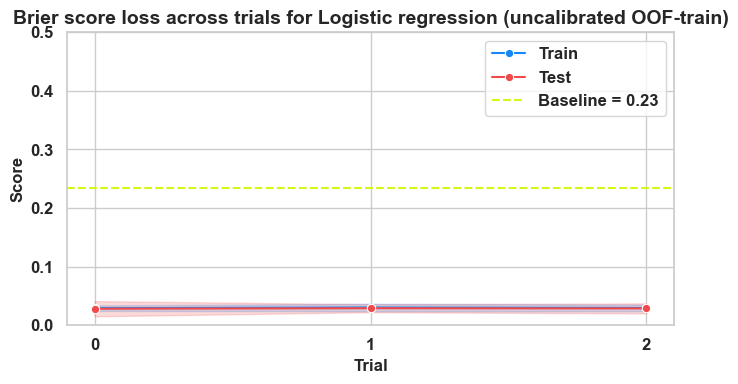

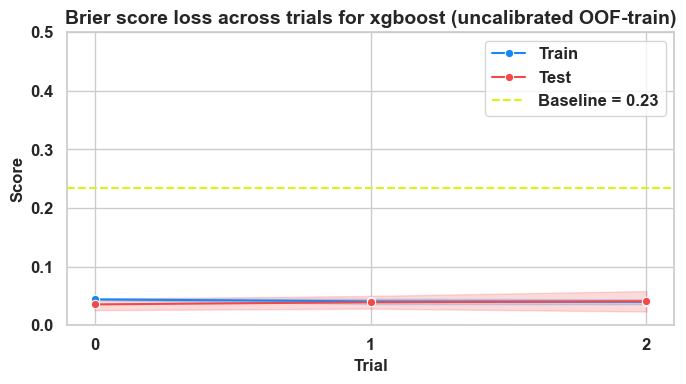

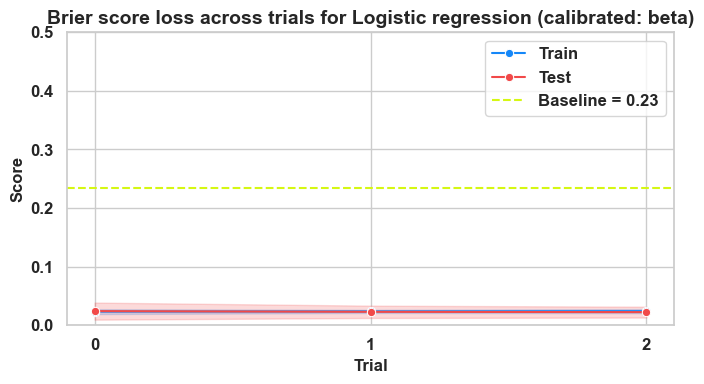

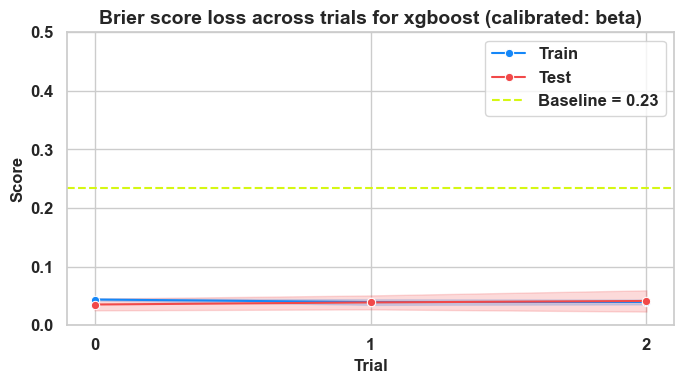

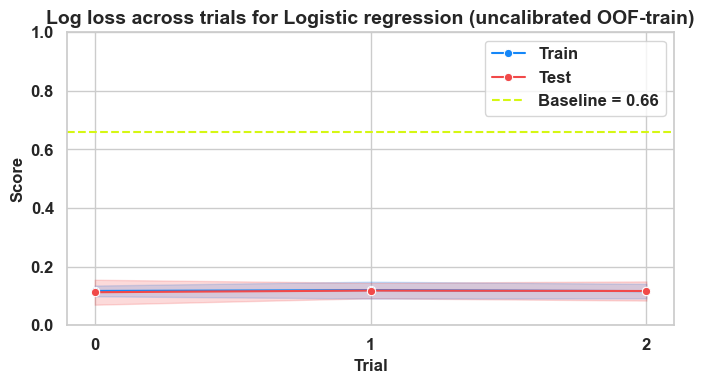

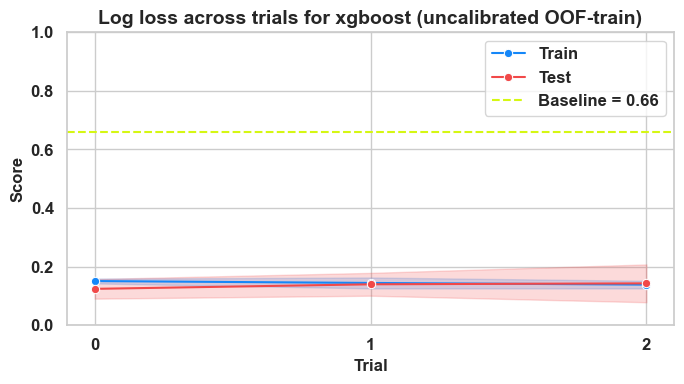

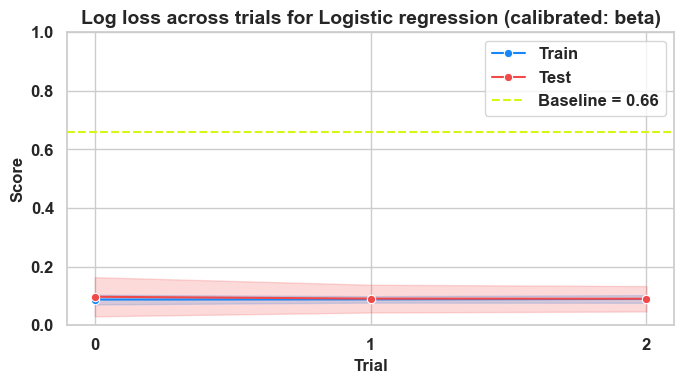

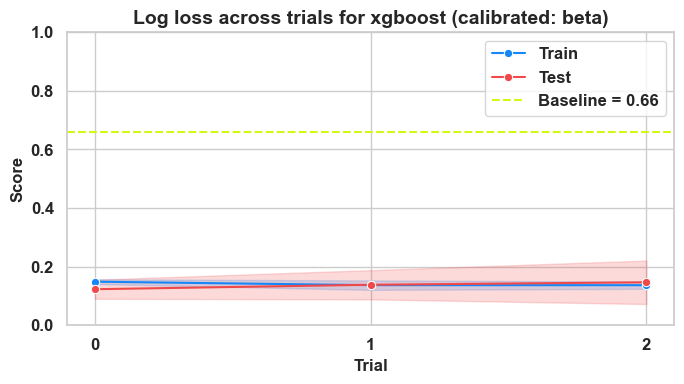

In [30]:
mtci.plot_metric_over_trials(
    eval_results,
    metric_name="brier_score_loss",
    use_calibrated=False,
    include_uncalib_oof=True,
    split_palette={"Train": "#1587F8", "Test": "#F14949"},
    method_alias={"logistic_regression": "Logistic regression"},
    figsize=(7, 4),
    font_size=12,
    legend_loc="best",
    xtick_step=1,
    y_lim=(0.0, 0.5),
    show_prevalence_baseline=True
)

mtci.plot_metric_over_trials(
    eval_results,
    metric_name="brier_score_loss",
    use_calibrated=True,
    calibration_method="beta",
    include_uncalib_oof=False,
    split_palette={"Train": "#1587F8", "Test": "#F14949"},
    method_alias={"logistic_regression": "Logistic regression"},
    figsize=(7, 4),
    font_size=12,
    legend_loc="best",
    xtick_step=1,
    y_lim=(0.0, 0.5),
    show_prevalence_baseline=True
)


mtci.plot_metric_over_trials(
    eval_results,
    metric_name="log_loss",
    use_calibrated=False,
    include_uncalib_oof=True,
    split_palette={"Train": "#1587F8", "Test": "#F14949"},
    method_alias={"logistic_regression": "Logistic regression"},
    figsize=(7, 4),
    font_size=12,
    legend_loc="best",
    xtick_step=1,
    y_lim=(0.0, 1.0),
    show_prevalence_baseline=True
)

mtci.plot_metric_over_trials(
    eval_results,
    metric_name="log_loss",
    use_calibrated=True,
    calibration_method="beta",
    include_uncalib_oof=False,
    split_palette={"Train": "#1587F8", "Test": "#F14949"},
    method_alias={"logistic_regression": "Logistic regression"},
    figsize=(7, 4),
    font_size=12,
    legend_loc="best",
    xtick_step=1,
    y_lim=(0.0, 1.0),
    show_prevalence_baseline=True
)
